# Import packages

In [1]:
#!pip install packagename
# importing modules
import geopandas as gpd
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import os
from os import chdir as cd
import time
import fiona
from datetime import date

# Places and Cities are synonymously used here

# Join shapefiles for all places to create one master file for the whole US

In [2]:
# # Exporting all shapefiles for plotting
# # Importing the places shapefiles for all states
# # combining them into one for further use
# from pathlib import Path
# # define the file location
# folder = Path(r"D:\Work\Box Sync\Trends_all states\Maps_2020\\")
# # reading the zip file
# shapefiles = folder.glob("tl_2020_*_place.zip")
# # combining places for US into one file
# gdf = pd.concat([gpd.read_file(shp) for shp in shapefiles]).pipe(gpd.GeoDataFrame)
# gdf = gdf.set_crs("EPSG:4269")
# gdf.to_file(folder / 'compiled.shp')

# Import all spatial data / vector data (shapefiles) for analysis

In [3]:
US_places = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\compiled.shp')
US_counties = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_county.zip')
US_states = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_state.zip') 

# source: https://gis.stackexchange.com/questions/141580/which-projection-is-best-for-mapping-the-contiguous-united-states
US_states = US_states.to_crs('EPSG:9311')
US_places = US_places.to_crs('EPSG:9311')
US_counties = US_counties.to_crs('EPSG:9311')

US_places.shape, US_counties.shape, US_states.shape

((32188, 17), (3234, 18), (56, 15))

# Import population data at Place (city) level from 2020 Census

In [4]:
# census population from 2020 data from cesus.gov
places_census2020 = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Population_DP05\DECENNIALPL2020.P1-Data.csv')
places_census2020 = places_census2020.tail(-1)
places_census2020
places_census2020['GEOID'] = places_census2020['GEO_ID'].str.slice(-7)
places_census2020['CensusPop_20'] = places_census2020['P1_001N'].astype(float)
population_2020 = places_census2020[['GEOID', 'CensusPop_20']]

C:\Users\uttar\AppData\Local\Temp\ipykernel_14648\1470313437.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  places_census2020 = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Population_DP05\DECENNIALPL2020.P1-Data.csv')


# Merging Places' spatial data with 2020 population

In [5]:
places_with_population = US_places.merge(population_2020 , on = 'GEOID', how = 'outer')

In [6]:
# replacing zero population values with NaN
places_with_population['CensusPop_20'].replace(0, np.nan, inplace = True)
places_with_population['CensusPop_20'].isna().sum(), places_with_population.shape

(327, (32188, 18))

# Import Mann_kendall analysis output

In [7]:
# Mann_kendall analysis output found from mk_Trend.py gives current trend for all places in the US
# the places that had trend identified is only listed in this file
# places that have less than three year population data couldn't be analyzed to calculate trend

places_attr = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\mktest_place_10-20_Continued_labeled.csv', index_col =0)
places_attr['P_19'] = places_attr['Pop_estimate'].str.split(',').str[-2].str.strip('[]').astype(float)
places_attr.rename(columns = {'NAME_x': 'NAME'}, inplace = True)
# slicing column value to match with shapefile for joining
places_attr['GEOID'] = places_attr['GEO_ID'].str.slice(-7)
places_attr['State'] = places_attr['GEOID'].str[:2]

print(f'Shape of the places_attr dataframe: {places_attr.shape}')
places_attr.head()

Shape of the places_attr dataframe: (29245, 33)


,GEO_ID,NAME,DP05_0001E,DP05_0001E_11,DP05_0001E_12,DP05_0001E_13,DP05_0001E_14,DP05_0001E_15,DP05_0001E_16,DP05_0001E_17,...,P_20,mean_changeRate,total_changeRate,mean_Rate,total_Rate,label,density_km2,P_19,GEOID,State
0,1600000US0102260,Ardmore,1167.0,1300.0,1380.0,1454.0,1511.0,1419.0,1526.0,1490.0,...,1347.0,0.016736,0.154242,0 < x <= 0.025,0.1 < x <= 0.5,6 moderately increasing,254.636434,1350.0,0102260,01
1,1600000US0151264,Mooresville,57.0,60.0,52.0,57.0,62.0,78.0,69.0,73.0,...,87.0,0.050253,0.526316,0.05 < x <= 0.25,x > 0.5,7 highly increasing,134.602621,84.0,0151264,01
2,1600000US0171496,Somerville,847.0,736.0,787.0,694.0,657.0,691.0,751.0,659.0,...,653.0,-0.018872,-0.229044,-0.025 < x <= 0,- 0.5 < x <= -0.1,3 slowly depopulating,73.406508,547.0,0171496,01
3,1600000US0176872,Trinity,2098.0,2112.0,2209.0,2157.0,2257.0,2239.0,2110.0,2068.0,...,2593.0,0.030600,0.235939,0.025 < x <= 0.05,0.1 < x <= 0.5,6 moderately increasing,201.607511,2493.0,0176872,01
4,1600000US0130880,Goshen,213.0,273.0,241.0,284.0,299.0,356.0,343.0,362.0,...,222.0,0.021680,0.042254,0 < x <= 0.025,0 < x <= 0.1,5 slowly increasing,33.460725,224.0,0130880,01


In [8]:
# Check number of values found from estimation
print('Current population trend for cities in the US (50 States with District of Columbia): \n')
print('Current Trend                No of cities')
print(places_attr['label'].value_counts())
print('\n')
print('Percent cities with different population trends: \n')
places_attr['label'].value_counts()/ places_attr['label'].value_counts().sum()

Current population trend for cities in the US (50 States with District of Columbia): 

Current Trend                No of cities
label
3 slowly depopulating        9017
6 moderately increasing      7298
5 slowly increasing          5628
7 highly increasing          3002
2 moderately depopulating    1853
4 fluctuating                1479
1 severely depopulating       968
Name: count, dtype: int64


Percent cities with different population trends: 



label
3 slowly depopulating        0.308326
6 moderately increasing      0.249547
5 slowly increasing          0.192443
7 highly increasing          0.102650
2 moderately depopulating    0.063361
4 fluctuating                0.050573
1 severely depopulating      0.033100
Name: count, dtype: float64

# Join attributes with 2020 Census population vector data

In [9]:
# joining tabular data with spatial data by merging the data files based on column name
# use 'outer' join and check unmatched datanames
places_merged_all = places_with_population.merge(places_attr.loc[:,['GEOID','Pop_estimate', 'P_19', 'P_20', 'trend','label', 'State']],
                                    on = 'GEOID', 
                                    how = 'outer', 
                                    indicator=True)

In [10]:
places_merged_all.shape, places_merged_all.columns

((32188, 25),
 Index(['STATEFP', 'PLACEFP', 'PLACENS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
        'CLASSFP', 'PCICBSA', 'PCINECTA', 'MTFCC', 'FUNCSTAT', 'ALAND',
        'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'CensusPop_20',
        'Pop_estimate', 'P_19', 'P_20', 'trend', 'label', 'State', '_merge'],
       dtype='object'))

In [11]:
print('Places that exist in the geographic file (US_places) but not in population data')
# these are places that changed NAME, GEOID or Both or merged or dropped
places_merged_all[places_merged_all['_merge'] == 'left_only'].sort_values('NAME').groupby(['STATEFP']).agg({'GEOID':'count',
                                                                                                            'P_19':'sum',
                                                                                                            'P_20':'sum',
                                                                                                            'CensusPop_20':'sum'}).sum()

Places that exist in the geographic file (US_places) but not in population data


GEOID              2943.0
P_19                  0.0
P_20                  0.0
CensusPop_20    4154494.0
dtype: float64

In [12]:
# excluding NaN values for census population since that will result in non-numeric population factor
places_merged = places_merged_all[places_merged_all['CensusPop_20'].notnull()] 
print(f'Dataframe after drop null values in CensusPop_20 column: {places_merged.shape}\n')

# Excluding Puerto Rico since Hauer's forecast do not have values for Puerto Rico
places_merged = places_merged[places_merged['STATEFP'] != '72']
print(f'Final dataframe for analysis: {places_merged.shape} \n')

places_merged[['STATEFP','GEOID', 'NAMELSAD','ALAND','CensusPop_20', 'Pop_estimate', 'P_19', 'P_20', 'trend', 'label',]].head()

Dataframe after drop null values in CensusPop_20 column: (31861, 25)

Final dataframe for analysis: (31569, 25) 



,STATEFP,GEOID,NAMELSAD,ALAND,CensusPop_20,Pop_estimate,P_19,P_20,trend,label
0,01,0102260,Ardmore town,5289895,1321.0,"[1167.0, 1300.0, 1380.0, 1454.0, 1511.0, 1419....",1350.0,1347.0,no trend,6 moderately increasing
1,01,0151264,Mooresville town,646347,47.0,"[57.0, 60.0, 52.0, 57.0, 62.0, 78.0, 69.0, 73....",84.0,87.0,increasing,7 highly increasing
2,01,0171496,Somerville town,8895669,796.0,"[847.0, 736.0, 787.0, 694.0, 657.0, 691.0, 751...",547.0,653.0,decreasing,3 slowly depopulating
3,01,0176872,Trinity town,12861624,2526.0,"[2098.0, 2112.0, 2209.0, 2157.0, 2257.0, 2239....",2493.0,2593.0,no trend,6 moderately increasing
4,01,0130880,Goshen town,6634644,269.0,"[213.0, 273.0, 241.0, 284.0, 299.0, 356.0, 343...",224.0,222.0,no trend,5 slowly increasing


Not everyone resides in a place; in 1990, approximately 66 million people (26 percent) in the United States lived outside of any place, \
either in small settlements, in the open countryside, or in the densely settled fringe of large cities in areas that were built-up, \
but not identifiable as places. 

In [13]:
# # As of the census, 26% of the people in the United States lived outside of places
# # Checking if the percent value matches with/ is close to total US population
places_merged['P_20'].sum()/(1-0.26), places_merged['CensusPop_20'].sum()/(1-0.26)
places_merged.shape

(31569, 25)

# Import County level population count from Census

In [14]:
county_population = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\County Population\DECENNIALPL2020.P1-Data.csv', header = 1)
county_population.shape, county_population[' !!Total:'].sum()

county_population['Total population'] = county_population[' !!Total:'].astype('float')
county_population['GEOID10'] = county_population['Geography'].str.slice(-5)

# Loading forecasted population data from Hauer

In [15]:
# loading forecasted population data from Hauer
%cd "D:\Work\Box Sync\Trends_all states\HauersProjection\county_projectios_Total_bySex_byRace\total_pop_proj"
county_Projection = gpd.read_file(r"hauer_county_totpop_SSPs.shp")

# contains 3221 rows, 3135 rows contains forecast values, these 3135 rows will be used for analysis
print(county_Projection.shape)

# 78 rows with zero data for counties in Puerto Rico 
# check coordinate system and project to similar coordinate system
# to change the coordinate system
county_Projection = county_Projection.to_crs('3528')
if county_Projection.crs != places_merged.crs:
    places_merged = places_merged.to_crs(county_Projection.crs)

places_merged.shape

D:\Work\Box Sync\Trends_all states\HauersProjection\county_projectios_Total_bySex_byRace\total_pop_proj
(3221, 104)


(31569, 25)

In [16]:
# merging projection data with county level census population
county_with_population = county_Projection.merge(county_population[['GEOID10', 'Geographic Area Name', 'Total population']],
                                                 on = 'GEOID10', 
                                                 how = 'outer', 
                                                 indicator = True)

In [17]:
# county_with_population[county_with_population['_merge'] == 'left_only']
# county_with_population[county_with_population['_merge'] == 'right_only']
# county_with_population[county_with_population['NAME10'].str.contains('Bedford') == True]

In [18]:
print(county_with_population['Total population'].dtypes)

# some places have changed their name or spelling but the area haven't changed
# To address those values Manual correction
county_with_population.loc[625,105] = 9719.0    # On January 2, 2019, it was abolished and replaced by the Chugach Census Area and the Copper River Census Area
county_with_population.loc[2754,105] = 13672.0  # Oglala Lakota County (known as Shannon County until May 2015
county_with_population.loc[173,105] = 8368      # Kusilvak Census Area, formerly known as Wade Hampton Census Area
# Excluding puerto Rico
county_with_population = county_with_population[county_with_population['STATEFP10'] != '72']
# Dropping NAN values
county_with_population.dropna(subset=['STATEFP10'], inplace=True)

float64


In [19]:
# NOT USING IT IN ANY RESULTS
df_P_20_with_margin = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\Population_2020_with_margin.csv', 
                                  index_col = 0)
df_P_20_with_margin['GEOID'] = df_P_20_with_margin['GEO_ID'].str.slice(-7)

# Distributing Hauer's county level forecast to city level

In [20]:
# A combined dataframe is created to distribute the county level forecast from Hauer's data to Plcaes/ Cities
# The county population is distributed based on population weights

combined_df = pd.DataFrame()
gdf = pd.DataFrame()

for state in county_with_population['STATEFP10'].sort_values().unique():
    # print('start...')
    # print('........')
    population_projection =  county_with_population[county_with_population['STATEFP10'] == state]
    places_population = places_merged[places_merged['STATEFP'] == state]
    
    # print(population_projection.head())
    # print('........')
    # print(places_population.head())
    
    if population_projection.crs == places_population.crs:
        # calculating total area from geometry # try using land/water ratio???? # didnt use geom_area, used ALAND area
        geom_overlayed = gpd.overlay(population_projection, places_population, how='intersection', keep_geom_type=False, make_valid=True)
        print(geom_overlayed.shape)

        geom_overlayed['intersect_area'] = geom_overlayed.area
    
        geom_overlayed['%area'] = geom_overlayed['intersect_area'] /geom_overlayed['ALAND'] 
        area_factor = pd.DataFrame()
        area_factor[['GEOID', 'COUNTY', 'area_factor']] = geom_overlayed.groupby(by = ['GEOID'])['%area'].apply(lambda x:(x/x.sum())).reset_index()
        geom_overlayed = geom_overlayed.merge(area_factor[['GEOID', 'area_factor']], on = 'GEOID')
        geom_overlayed['landarea'] = geom_overlayed['ALAND'] / (1000*1000)
        # density in km2
        geom_overlayed['density'] = geom_overlayed['CensusPop_20']/geom_overlayed['landarea'] # 'P_20'
        geom_overlayed['P_20_adjusted'] = geom_overlayed['area_factor'] * geom_overlayed['density'] * geom_overlayed['landarea']
        # what percent of county population lives in this place
        geom_overlayed['population_factor'] = geom_overlayed['P_20_adjusted'] / geom_overlayed['Total population'] #.apply(lambda x:(x/x.sum()))
    
        # geom_overlayed['population_factor'] = geom_overlayed.groupby(by = ['STATEFP', 'NAMELSAD10'])['P_20_adjusted'].apply(lambda x:(x/x.sum()))
        geom_overlayed['population_factor'] = geom_overlayed['population_factor'].fillna(0)
        # normalizing population factor so that county total becomes 1
        # geom_overlayed['population_factor'] = geom_overlayed.groupby(by = ['STATEFP10', 'NAMELSAD10'])['population_factor'].apply(lambda x:(x/x.sum()))
        # print(geom_overlayed.shape)
        print(geom_overlayed.columns[18], geom_overlayed.columns[102])
        for colidx in range(18,103):                # columns that contains county sums
            column_name =  'forecast_' + str(geom_overlayed.columns[colidx])
            geom_overlayed[column_name] = (geom_overlayed.iloc[:,colidx] * geom_overlayed['population_factor']).round(0)
        
        # gdf is used to make the plot
        # gdf contains ungrouped data by GEOID
        gdf = pd.concat([gdf, geom_overlayed])
    
        column_name = geom_overlayed.columns[139:234] # taking the columns that have forecasted dataset
        print('for check: State ' + state + '  column name ' + column_name[0] + ' ' + column_name[-1])
        forecasted_df = pd.DataFrame()
        forecasted_df = geom_overlayed.groupby(by = ['GEOID', 'CensusPop_20'], as_index=False)[column_name].apply(lambda x:(x.sum()))

        county_names = geom_overlayed.groupby(by = ['GEOID'], as_index=False).agg({'COUNTYFP10': 'first', 'NAME10': 'count'})
        forecasted_df =  forecasted_df.merge(county_names, on = 'GEOID')
    
    
        df_with_MOE = forecasted_df.merge(df_P_20_with_margin[df_P_20_with_margin['GEOID'].str.startswith(state)][['P_20_upper', 
                                                                                                               'P_20_lower','NAME', 'GEOID',]], on = 'GEOID')
    
        df_with_MOE['MOE'] = (df_with_MOE['P_20_upper']- df_with_MOE['P_20_lower'])/2
        df_with_MOE['diff'] = (df_with_MOE['P_20_upper']- df_with_MOE['MOE']- df_with_MOE['forecast_ssp32020'])
        df_with_MOE['diff'] = df_with_MOE['diff'].replace(-np.inf, np.nan)
        # print('Completed for state: ' + state)

        combined_df = pd.concat([combined_df, df_with_MOE])
    else:
        print('check coordinate system')
    

(755, 132)
ssp12020 ssp52100
for check: State 01  column name forecast_ssp12020 forecast_ssp52100
(376, 132)
ssp12020 ssp52100
for check: State 02  column name forecast_ssp12020 forecast_ssp52100
(512, 132)
ssp12020 ssp52100
for check: State 04  column name forecast_ssp12020 forecast_ssp52100
(708, 132)
ssp12020 ssp52100
for check: State 05  column name forecast_ssp12020 forecast_ssp52100
(1865, 132)
ssp12020 ssp52100
for check: State 06  column name forecast_ssp12020 forecast_ssp52100
(583, 132)
ssp12020 ssp52100
for check: State 08  column name forecast_ssp12020 forecast_ssp52100
(250, 132)
ssp12020 ssp52100
for check: State 09  column name forecast_ssp12020 forecast_ssp52100
(82, 132)
ssp12020 ssp52100
for check: State 10  column name forecast_ssp12020 forecast_ssp52100
(1, 132)
ssp12020 ssp52100
for check: State 11  column name forecast_ssp12020 forecast_ssp52100
(1161, 132)
ssp12020 ssp52100
for check: State 12  column name forecast_ssp12020 forecast_ssp52100
(904, 132)
ssp12020 s

In [21]:
# # A combined dataframe is created to distribute the county level forecast from Hauer's data to Plcaes/ Cities
# # The county population is distributed based on population weights

# combined_df = pd.DataFrame()
# gdf = pd.DataFrame()

# for state in county_Projection['STATEFP10'].sort_values().unique():
#     # print('start...')
#     # print('........')
#     population_projection =  county_with_population[county_with_population['STATEFP10'] == state]
#     places_population = places_merged[places_merged['STATEFP'] == state]
    
#     # print(population_projection.head())
#     # print('........')
#     # print(places_population.head())
    
#     if population_projection.crs == places_population.crs:
#         # calculating total area from geometry # try using land/water ratio???? # didnt use geom_area, used ALAND area
#         geom_overlayed = gpd.overlay(population_projection, places_population, how='intersection', keep_geom_type=False, make_valid=True)
#         print(geom_overlayed.shape)

#         geom_overlayed['intersect_area'] = geom_overlayed.area
    
#         geom_overlayed['%area'] = geom_overlayed['intersect_area'] /geom_overlayed['ALAND'] 
#         geom_overlayed['area_factor'] = geom_overlayed.groupby(by = ['GEOID'])['%area'].apply(lambda x:(x/x.sum())).reset_index()
#         geom_overlayed['landarea'] = geom_overlayed['ALAND'] / (1000*1000)
#         # density in km2
#         geom_overlayed['density'] = geom_overlayed['CensusPop_20']/geom_overlayed['landarea'] # 'P_20'
#         geom_overlayed['P_20_adjusted'] = geom_overlayed['area_factor'] * geom_overlayed['density'] * geom_overlayed['landarea']
#         # what percent of county population lives in this place
#         geom_overlayed['population_factor'] = geom_overlayed['P_20_adjusted'] / geom_overlayed['Total population'] #.apply(lambda x:(x/x.sum()))
    
#         # geom_overlayed['population_factor'] = geom_overlayed.groupby(by = ['STATEFP', 'NAMELSAD10'])['P_20_adjusted'].apply(lambda x:(x/x.sum()))
#         geom_overlayed['population_factor'] = geom_overlayed['population_factor'].fillna(0)
#         # normalizing population factor so that county total becomes 1
#         # geom_overlayed['population_factor'] = geom_overlayed.groupby(by = ['STATEFP10', 'NAMELSAD10'])['population_factor'].apply(lambda x:(x/x.sum()))
#         # print(geom_overlayed.shape)
#         for colidx in range(18,103):                # columns that contains county sums
#             column_name =  'forecast_' + str(geom_overlayed.columns[colidx])
#             geom_overlayed[column_name] = (geom_overlayed.iloc[:,colidx] * geom_overlayed['population_factor']).round(0)
        
#         # gdf is used to make the plot
#         # gdf contains ungrouped data by GEOID
#         gdf = pd.concat([gdf, geom_overlayed])
    
#         column_name = geom_overlayed.columns[139:234] # taking the columns that have forecasted dataset
#         print('for check: ' + column_name[0] + ' ' + column_name[-1])
#         forecasted_df = pd.DataFrame()
#         forecasted_df = geom_overlayed.groupby(by = ['GEOID', 'CensusPop_20'], as_index=False)[column_name].apply(lambda x:(x.sum()))

#         county_names = geom_overlayed.groupby(by = ['GEOID'], as_index=False).agg({'COUNTYFP10': 'first', 'NAME10': 'count'})
#         forecasted_df =  forecasted_df.merge(county_names, on = 'GEOID')
    
    
#         df_with_MOE = forecasted_df.merge(df_P_20_with_margin[df_P_20_with_margin['GEOID'].str.startswith(state)][['P_20_upper', 
#                                                                                                                'P_20_lower','NAME', 'GEOID',]], on = 'GEOID')
    
#         df_with_MOE['MOE'] = (df_with_MOE['P_20_upper']- df_with_MOE['P_20_lower'])/2
#         df_with_MOE['diff'] = (df_with_MOE['P_20_upper']- df_with_MOE['MOE']- df_with_MOE['forecast_ssp32020'])
#         df_with_MOE['diff'] = df_with_MOE['diff'].replace(-np.inf, np.nan)
#         # print('Completed for state: ' + state)

#         combined_df = pd.concat([combined_df, df_with_MOE])
#     else:
#         print('check coordinate system')
    
    
    
# combined_df.shape

In [22]:
# gdf[(gdf['STATEFP'] == '17') & (gdf['%area'] > 0.01)].groupby(['NAMELSAD']).size().sort_values()[-1]
# plotting_city = gdf[(gdf['STATEFP'] == '17') & (gdf['NAMELSAD'] =='Aurora city') & (gdf['%area'] > 0.001)]

# fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 7))
# plotting_city.plot(ax= ax, column = 'NAMELSAD10', legend = True, 
#                    cmap = 'tab20b', legend_kwds={'loc': 'lower left','fontsize': 14})
# ax.set_title(str('Aurora city'), fontsize=20, pad=5)
# ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

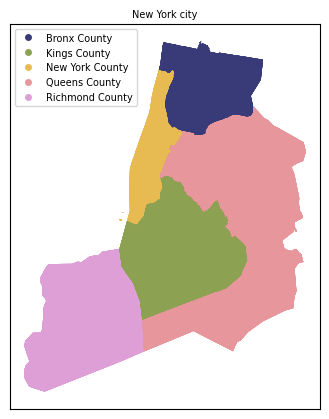

In [25]:
# =====================================================
# # Some cities are part of multiple counties, find the city that is overlaped by maximum counties
# =====================================================
city_name = 'New York city'
plotting_city = gdf[(gdf['NAMELSAD'] ==city_name) & (gdf['%area'] > 0.001)]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 5))
plotting_city.plot(ax= ax, column = 'NAMELSAD10', legend = True, 
                   cmap = 'tab20b', legend_kwds={'loc': 'upper left','fontsize': 7,
                                                'markerscale' : 0.5})
ax.set_title(str(city_name), fontsize=7, pad=5)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
fig.savefig(r'D:\Work\Box Sync\NC Figures\\' + str(city_name) + '.pdf', 
            dpi =300, bbox_inches='tight')


In [26]:
# Combined_df is obtained by distributing Hauer's county level forecast
df_Hauer = combined_df.reset_index(drop= True).copy()

# Import NCAR city level aggregated (1km grid level is converted to city level) data as csv

In [27]:
# This dataset is derived using raster to vector conversion analyzed and saved from 0 SSPGeotiff2Population.ipynb and 0 merge_agg_NCAR_pop.ipynb
pop_from_NCAR = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Spatial_Population_geotiff\Population from SSP\r_concat_SSP\NCAR_agg_scenarios.csv',
                            index_col = 0, dtype = {'GEOID_ssp5': str})

df_NCAR = pop_from_NCAR.copy()

# Merging both forecasts (Hauer's and NCAR)

In [28]:
print('Cells with zero population count in 2020 for scenario SSP 4: ')
print('From NCAR:---'), print(df_NCAR[df_NCAR['population_2020_ssp4'] == 0].shape[0])
print('From Hauer:---'), print(df_Hauer[df_Hauer['forecast_ssp42020'] == 0].shape[0])
print(df_NCAR.shape, df_Hauer.shape,)

Cells with zero population count in 2020 for scenario SSP 4: 
From NCAR:---
172
From Hauer:---
66
(32188, 160) (31568, 94)


In [29]:
# MERGING TWO DATASETS
right_on_column_name = 'GEOID_ssp5'
df_both_combined = df_Hauer.merge(df_NCAR, left_on = 'GEOID', right_on = right_on_column_name, how = 'outer', indicator = True )
# df_both_combined.columns, 
df_both_combined.shape

(32188, 255)

In [30]:
df_both_combined.columns

Index(['GEOID', 'CensusPop_20', 'forecast_ssp12020', 'forecast_ssp22020',
       'forecast_ssp32020', 'forecast_ssp42020', 'forecast_ssp52020',
       'forecast_ssp12025', 'forecast_ssp22025', 'forecast_ssp32025',
       ...
       'std_2080_ssp5', 'population_2090_ssp5', 'meanpop_2090_ssp5',
       'std_2090_ssp5', 'NAMELSAD_2100_ssp5', 'population_2100_ssp5',
       'meanpop_2100_ssp5', 'std_2100_ssp5', 'GEOID_ssp5', '_merge'],
      dtype='object', length=255)

In [31]:
df_both_combined[df_both_combined['_merge'] == 'left_only'].shape, \
df_both_combined[df_both_combined['_merge'] == 'right_only'].shape, \
df_both_combined[df_both_combined['_merge'] == 'both'].shape, 

((0, 255), (620, 255), (31568, 255))

In [32]:
# Common to both dataframes
df_complete = df_both_combined[df_both_combined['_merge'] == 'both'].reset_index(drop=True)
print('No of cities common to both datasets: ' + str(df_complete.shape[0]))

No of cities common to both datasets: 31568


In [33]:
df_complete

,GEOID,CensusPop_20,forecast_ssp12020,forecast_ssp22020,forecast_ssp32020,forecast_ssp42020,forecast_ssp52020,forecast_ssp12025,forecast_ssp22025,forecast_ssp32025,...,std_2080_ssp5,population_2090_ssp5,meanpop_2090_ssp5,std_2090_ssp5,NAMELSAD_2100_ssp5,population_2100_ssp5,meanpop_2100_ssp5,std_2100_ssp5,GEOID_ssp5,_merge
0,0100100,133.0,268.0,266.0,262.0,266.0,272.0,265.0,264.0,253.0,...,13.473181,201.617676,18.589199,14.036127,Abanda CDP,206.469437,19.036531,14.373895,0100100,both
1,0100124,2358.0,2376.0,2366.0,2320.0,2353.0,2414.0,2370.0,2353.0,2259.0,...,130.503860,5188.781250,93.971718,135.938690,Abbeville city,5315.295898,96.262962,139.242203,0100124,both
2,0100460,4366.0,4328.0,4316.0,4225.0,4288.0,4410.0,4349.0,4330.0,4150.0,...,234.537842,14045.753906,146.714371,252.531265,Adamsville city,14842.404297,155.035751,267.170074,0100460,both
3,0100484,659.0,654.0,652.0,639.0,648.0,665.0,634.0,629.0,604.0,...,36.246891,951.719604,68.691185,37.700645,Addison town,975.641724,70.417786,38.648273,0100484,both
4,0100676,225.0,222.0,221.0,216.0,219.0,225.0,212.0,210.0,202.0,...,80.533821,388.768585,156.531235,84.234352,Akron town,399.617584,160.899414,86.720467,0100676,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31563,5684852,118.0,130.0,129.0,127.0,129.0,132.0,139.0,139.0,133.0,...,3.318814,89.912880,1.346410,3.355208,Woods Landing-Jelm CDP,89.979752,1.347411,3.356666,5684852,both
31564,5684925,4773.0,5111.0,5089.0,4985.0,5059.0,5197.0,4973.0,4936.0,4734.0,...,574.137512,8891.083008,457.706024,619.472107,Worland city,9423.322266,485.105286,656.561462,5684925,both
31565,5685015,1644.0,1864.0,1862.0,1820.0,1848.0,1904.0,1988.0,1984.0,1896.0,...,21.698034,278.370056,21.975481,23.506205,Wright town,278.370056,21.975481,23.506205,5685015,both
31566,5686665,131.0,146.0,146.0,143.0,145.0,149.0,150.0,149.0,142.0,...,49.446781,112.434563,130.600113,51.491573,Yoder town,114.667023,133.193268,52.513969,5686665,both


# Plotting total forecasts from two datasets for all scenarios

In [34]:
# def df_total_population(dataframe, filter_regex,label_name, *list_of_years):
#     list_of_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100]
#     df = (dataframe[(dataframe.filter(regex=filter_regex).columns)].sum()/1000000).to_frame(
#     name= label_name).reset_index(drop= True)
#     df['Year'] = pd.to_datetime(list_of_years,  format='%Y')
#     return df
    
# df_ssp1 = df_total_population(df_complete,'forecast_ssp1', 'Hauer SSP 1',)
# df_ssp2 = df_total_population(df_complete,'forecast_ssp2', 'Hauer SSP 2',)
# df_ssp3 = df_total_population(df_complete,'forecast_ssp3', 'Hauer SSP 3',)
# df_ssp4 = df_total_population(df_complete,'forecast_ssp4', 'Hauer SSP 4',)
# df_ssp5 = df_total_population(df_complete,'forecast_ssp5', 'Hauer SSP 5',)
# df_ssp1 = df_total_population(df_complete,'forecast_ssp1', 'Hauer SSP 1',)
# df_ssp2 = df_total_population(df_complete,'forecast_ssp2', 'Hauer SSP 2',)
# df_ssp3 = df_total_population(df_complete,'forecast_ssp3', 'Hauer SSP 3',)
# df_ssp4 = df_total_population(df_complete,'forecast_ssp4', 'Hauer SSP 4',)
# df_ssp5 = df_total_population(df_complete,'forecast_ssp5', 'Hauer SSP 5',)

# # EXCLUDING STATE 72 SINCE FORECASTS DO NOT CONTAIN PUERTO RICO
# places_pop_ACS = places_attr[places_attr['State'] != 72]
# df_ACS = (places_pop_ACS[(places_pop_ACS.filter(regex='DP05_0001E').columns)].sum()/1000000).to_frame(
#     name= 'Total_population from ACS').reset_index(drop= True)

# df_ACS['Year'] = pd.to_datetime([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],  format='%Y')
# # Replacing ACS 2020 value by Census value 2020
# df_ACS.iloc[10,0] = places_pop_ACS.merge(df_complete[['GEOID', 'CensusPop_20']], on = 'GEOID', how = 'left')['CensusPop_20'].sum()/1000000


# fig, ax = plt.subplots(1,1, figsize=(15,6))
# df_ACS.plot(ax=ax, x= 'Year', y = 'Total_population from ACS', color = 'black', linewidth = 2, alpha = 1)
# df_ssp1.plot(ax=ax, x= 'Year', y = 'Hauer SSP 1', color = 'orangered')
# df_ssp2.plot(ax=ax, x= 'Year', y = 'Hauer SSP 2', color = 'peru', )
# df_ssp3.plot(ax=ax, x= 'Year', y = 'Hauer SSP 3', color = 'goldenrod', )
# df_ssp4.plot(ax=ax, x= 'Year', y = 'Hauer SSP 4', color = 'olivedrab', )
# df_ssp5.plot(ax=ax, x= 'Year', y = 'Hauer SSP 5', color = 'lightskyblue',)

# # df_total_pop_ssp = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\df_total_pop_from_SSPs_new.csv', index_col = 0,)
# df_total_pop_ssp = pd.read_csv(r'D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\r_concat_SSP\NCAR_agg_scenarios_totals.csv')
# df_total_pop_ssp['Year'] = pd.to_datetime(['2010', '2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090', '2100'],  format='%Y')
# # df_total_pop_ssp = df_total_pop_ssp.iloc[:3,:]
# df_total_pop_ssp.columns
# df_total_pop_ssp.plot(ax=ax, x = 'Year', y = ['NCAR SSP 1', 'NCAR SSP 2', 'NCAR SSP 3', 'NCAR SSP 4', 'NCAR SSP 5'], 
#                       color = ['red', 'sienna', 'darkorange', 'darkgreen', 'steelblue'], linestyle = 'dashed')
# ax.legend(bbox_to_anchor=(1, 1.05))

# ax.set_title('US population in millions for all places as defined by the US census', pad =5)

# Error in forecast when compared with 2020 census population

In [35]:
# diff of error terms: https://www.baeldung.com/cs/mape-vs-wape-vs-wmape
# ======================================================================

df_MAPE = df_complete.copy()

print(df_MAPE.shape)


# MEAN ABSOLUTE PERCENT ERROR
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def calculate_mape(df, actual_col, predict_col):
    return round(MAPE(df[actual_col], df[predict_col]), 2)

# MAPE < 10 is considered good forecast from the source below
# https://www.researchgate.net/publication/257812432_Using_the_R-MAPE_index_as_a_resistant_measure_of_forecast_accuracy/citations

error_from_hauer_mape = [calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp12020'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp22020'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp32020'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp42020'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp52020')]

error_from_NCAR_mape = [calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp1'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp2'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp3'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp4'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp5')]

# print('\n')
# print('Mean absolute percent error for Hauer and NCAR respectively:---')
# print(error_from_hauer, error_from_NCAR)

# WEIGHTED ABSOLUTE PERCENT ERROR (WAPE)
#Defining MAPE function
def WAPE(Y_actual,Y_Predicted):
    wape = np.sum(np.abs(Y_actual - Y_Predicted)) *100/np.sum(Y_actual)
    return wape

def calculate_wape(df, actual_col, predict_col):
    return WAPE(df[actual_col], df[predict_col]).round(2)


error_from_hauer_wape = [calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp12020'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp22020'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp32020'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp42020'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp52020')]

error_from_NCAR_wape = [calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp1'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp2'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp3'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp4'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp5')]

# print('\n')
# print('Weighted absolute percent error for Hauer and NCAR respectively:---')
# print(error_from_hauer, error_from_NCAR)

# WEIGHTED MEAN ABSOLUTE PERCENT ERROR (WMAPE)
#Defining WMAPE function
def WMAPE(Y_actual,Y_Predicted, weights):
    wmape = np.sum(np.abs(Y_actual - Y_Predicted)* weights) *100/np.sum(Y_actual*weights)
    return wmape

def calculate_wmape(df, actual_col, predict_col, weight_col):
    return WMAPE(df[actual_col], df_MAPE[predict_col], df_MAPE[weight_col]).round(2)

df_MAPE['normalized_pop']= (df_MAPE['CensusPop_20'] - df_MAPE['CensusPop_20'].min())/(df_MAPE['CensusPop_20'].max()-df_MAPE['CensusPop_20'].min())

error_from_hauer_wmape = [calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp12020', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp22020', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp32020', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp42020', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp52020', 'normalized_pop')]

error_from_NCAR_wmape = [calculate_wmape(df_MAPE, 'CensusPop_20', 'population_2020_ssp1', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20','population_2020_ssp2', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20','population_2020_ssp3', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20','population_2020_ssp4', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20','population_2020_ssp5', 'normalized_pop')]



(31568, 255)


Text(0.5, 1.0, 'Absolute Percent Errors \n (weighted by population)')

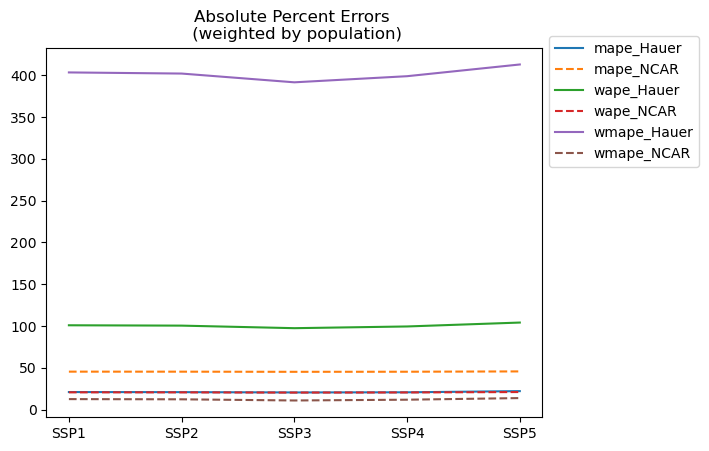

In [36]:
error_values_hauer1 = error_from_hauer_mape
error_values_NCAR1 = error_from_NCAR_mape
error_values_hauer2 = error_from_hauer_wape
error_values_NCAR2 = error_from_NCAR_wape
error_values_hauer2 = error_from_hauer_wape
error_values_NCAR2 = error_from_NCAR_wape
error_values_hauer3 = error_from_hauer_wmape
error_values_NCAR3 = error_from_NCAR_wmape

plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_hauer1, label="mape_Hauer")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_NCAR1, '--', label="mape_NCAR")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_hauer2, label="wape_Hauer")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_NCAR2, '--', label="wape_NCAR")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_hauer3, label="wmape_Hauer")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_NCAR3, '--', label="wmape_NCAR")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.title('Absolute Percent Errors \n (weighted by population)')

Since Hauer's data over predict and NCAR underpredict we use an weighted average of these two for three scenarios: SSP 1, SSP 2 and SSP 4. \
We dropped 3 and 5 since 5 shows an insanely high pattern and the baseline conditions that is huge dependence on fossil fuel is not possible. \
SSP 3 shows an rapid decreasing rate in population, which is no way align with current population trend.

# Forecasting Trend in population from 2020-2100

<Axes: >

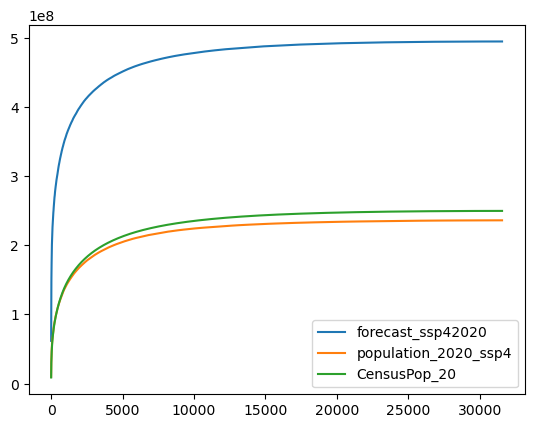

In [37]:
df_cumsum = df_complete[['forecast_ssp42020','population_2020_ssp4','CensusPop_20']].sort_values(by= 'CensusPop_20', 
                                                                                                 ascending = False).reset_index(drop= True)
df_cumsum.cumsum().plot()

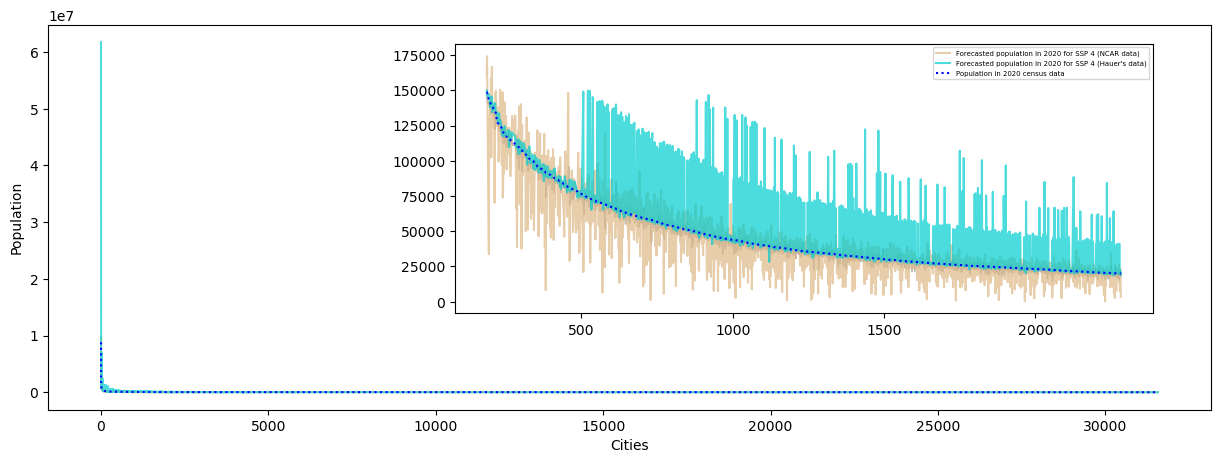

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df_main = df_complete.sort_values('CensusPop_20', ascending = False).reset_index()
df_inset= df_main[(df_main['forecast_ssp42020'] < 150000) & (df_main['CensusPop_20'] > 20000)]

fig, ax = plt.subplots(1, 1, figsize=[15, 5])
ax.plot(df_main.index, df_main['population_2020_ssp4'],"burlywood", alpha = 0.7, label = 'forecasted population 2040 for SSP 4');
ax.plot(df_main.index, df_main['forecast_ssp42020'], "darkturquoise", alpha = 0.7, label = 'forecasted population 2020 for SSP 4');
ax.plot(df_main.index, (df_main['CensusPop_20']), "b", linestyle='dotted', linewidth=1.5, label = 'Population in 2020 census data')

ax1 = ax.inset_axes((0.35,0.25,.6,.7)) #inset_axes(ax, width="50%", height=2, loc=2, borderpad=5)

ax1.plot(df_inset.index, df_inset['population_2020_ssp4'],"burlywood", alpha = 0.7, label = 'Forecasted population in 2020 for SSP 4 (NCAR data)');
ax1.plot(df_inset.index, df_inset['forecast_ssp42020'], "darkturquoise", alpha = 0.7, label = "Forecasted population in 2020 for SSP 4 (Hauer's data)");
ax1.plot(df_inset.index, (df_inset['CensusPop_20']), "b",linestyle='dotted', linewidth=1.5, label = 'Population in 2020 census data')

ax1.fill_between(df_inset.index, df_inset['P_20_upper'], df_inset['P_20_lower'], color="grey", alpha=0.5);

display = (0,1,2,3,4)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend([handle for i,handle in enumerate(handles) if i in display],
           [label for i,label in enumerate(labels) if i in display], loc = 'upper right', fontsize = 5)


# Turn ticklabels of insets off
for axi in [ax, ax1]:
    axi.tick_params(labelleft=True, labelbottom=True)
ax.set_xlabel('Cities')
ax.set_ylabel('Population')
plt.show()

# fig.savefig(r'D:\Work\Box Sync\PhD_Work_Uttara\NC_submission_shared\Final_submission\Final_plots\Plot variation in estimation and projected values.png', dpi = 300,
           # bbox_inches='tight', transparent="True", pad_inches=0)

In [39]:
len(df_complete.filter(regex= 'forecast').columns), len(df_complete.filter(regex= 'population_').columns)

(85, 50)

In [40]:
# A few checks on the dataset ---
# 15 CITIES IN ALASKA ARE COMMON WITH NO FORECAST AVAILABLE
df_complete[(df_complete['population_2020_ssp4'] == 0) & (df_complete['forecast_ssp42020'] == 0)][['GEOID', 'NAME','forecast_ssp42020', 
                                                                                                   'population_2020_ssp4','CensusPop_20']]
# 155 CITIES HAVE NO FORECAST AVAILABLE FROM NCAR DATA, THEY HAVE A MEAN POPULATION OF 228 with maximum 3102
# THIS ARE CITIES FROM ALASKA - California - NEVADA - New Mexico - 	Oregon - South Dakota - Wyoming
df_complete[df_complete['population_2020_ssp4'] == 0][['GEOID', 'NAME','forecast_ssp42020', 'population_2020_ssp4','CensusPop_20']]
# 73 CITIES HAVE NO FORECAST AVAILABLE FROM HAUER DATA, THEY HAVE A MEAN POPULATION OF 533 with maximum 3985
# THIS ARE CITIES FROM ALASKA AND SOUTH DAKOTA
df_complete[df_complete['forecast_ssp42020'] == 0][['GEOID', 'NAME','forecast_ssp42020', 'population_2020_ssp4','CensusPop_20']]
df_complete[['forecast_ssp42020','population_2020_ssp4','CensusPop_20']].isna().sum()

forecast_ssp42020       0
population_2020_ssp4    0
CensusPop_20            0
dtype: int64


Some cities are underprojectd by both datasets while some are overprojected. \
Therefore, we weighted the datasets based on whether they are ----  \
underprojected, overprojected or lie in the middle.


In [41]:
df_complete['%diff_Hauer'] = (df_complete['CensusPop_20'] - df_complete['forecast_ssp42020']) / df_complete['CensusPop_20']
df_complete['%diff_NCAR'] = (df_complete['CensusPop_20'] - df_complete['population_2020_ssp4']) / df_complete['CensusPop_20']
df_complete_middle = df_complete[((df_complete['%diff_Hauer'] >= 0) & (df_complete['%diff_NCAR'] <= 0)) | \
                                 ((df_complete['%diff_Hauer'] <= 0) & (df_complete['%diff_NCAR'] >= 0))]
df_complete_middle.shape

(15795, 257)

============== For cities in the Middle ==============

1051.3171172051063


<Axes: >

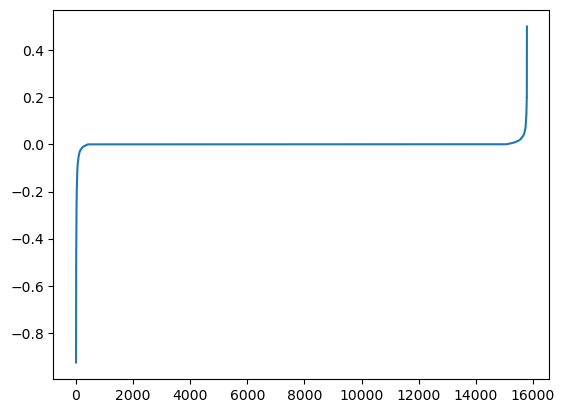

In [42]:
df11 = df_complete_middle.copy()

df11['diff_Hauer'] = np.abs(df11['CensusPop_20'] - df11['forecast_ssp42020']) 
df11['diff_NCAR'] = np.abs(df11['CensusPop_20'] - df11['population_2020_ssp4']) 


df11['w1']  = 1 / df11['diff_Hauer'] #(df_complete['diff_Hauer'] - min_val) / (max_val - min_val)
df11['w2']  = 1 / df11['diff_NCAR'] #(df_complete['diff_NCAR'] - min_val) / (max_val - min_val)

# df_complete['w1'] = (df_complete['diff_Hauer'] - df_complete['diff_Hauer'].min()) / (df_complete['diff_Hauer'].max() - df_complete['diff_Hauer'].min())
# df_complete['w2'] = (df_complete['diff_NCAR'] - df_complete['diff_NCAR'].min()) / (df_complete['diff_NCAR'].max() - df_complete['diff_NCAR'].min())

df11['w1'].replace(np.inf, 1, inplace =  True,)
df11['w2'].replace(np.inf, 1, inplace =  True)

df11['w3'] = df11['w1']/ (df11['w1'] + df11['w2'])
df11['w4'] = df11['w2']/ (df11['w1'] + df11['w2'])

df11['new'] = df11['w3']* df11['forecast_ssp42020'] + df11['w4'] * df11['population_2020_ssp4']
print(np.sum(np.abs(df11['new'] - df11['CensusPop_20'])) ) #/ np.sum(df_complete['CensusPop_20']))
df11['%diff'] = ((df11['CensusPop_20']-df11['new'])) /df11['CensusPop_20']
df11['diff'] = ((df11['CensusPop_20']-df11['new']))

df11['%diff'].sort_values().reset_index(drop=True).plot()

In [43]:
# df11[['GEOID', 'NAME','CensusPop_20', 'forecast_ssp42020', 'population_2020_ssp4',
#       'new', 'diff_Hauer', 'diff_NCAR',  'w1', 'w2', 'w3', 'w4', '%diff', 'diff']].sort_values(by = 'diff')
df11[['new', 'CensusPop_20', 'forecast_ssp42020', 'population_2020_ssp4',]].sum()

new                     1.171347e+08
CensusPop_20            1.171350e+08
forecast_ssp42020       2.060062e+08
population_2020_ssp4    9.967472e+07
dtype: float64

In [44]:
df_complete_under = df_complete[((df_complete['%diff_Hauer'] > 0) & (df_complete['%diff_NCAR'] > 0))]
df_complete_over = df_complete[((df_complete['%diff_Hauer'] < 0) & (df_complete['%diff_NCAR'] < 0))]

In [45]:
df_complete_under.shape, df_complete_over.shape

((10249, 257), (5524, 257))

============== For underprojected cities ==============

29981.500000000204


<Axes: >

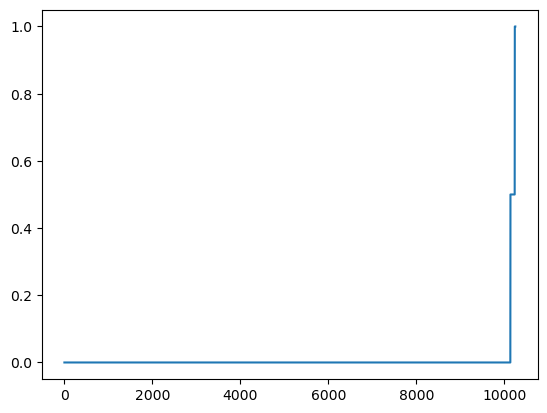

In [46]:
df22 = df_complete_under.copy()

df22['diff_Hauer'] = 1 /(df22['forecast_ssp42020'] / df22['CensusPop_20'])   # here diff refers to ratio
df22['diff_NCAR'] = 1 /(df22['population_2020_ssp4'] / df22['CensusPop_20'])

df22['w1'] = df22['diff_Hauer'] 
df22['w2'] = df22['diff_NCAR']

df22['w1'].replace(np.inf, 1, inplace =  True,)
df22['w2'].replace(np.inf, 1, inplace =  True)

df22['w3'] = df22['w1']/ 2
df22['w4'] = df22['w2']/ 2

df22['new'] = df22['w3']* df22['forecast_ssp42020'] + df22['w4'] * df22['population_2020_ssp4']
print(np.sum(np.abs(df22['new'] - df22['CensusPop_20'])) ) #/ np.sum(df_complete['CensusPop_20']))
df22['%diff'] = ((df22['CensusPop_20']-df22['new'])) /df22['CensusPop_20']
df22['diff'] = ((df22['CensusPop_20']-df22['new']))

df22['%diff'].sort_values().reset_index(drop=True).plot()

============== For overprojected cities ==============

5.174847217404022e-10


<Axes: >

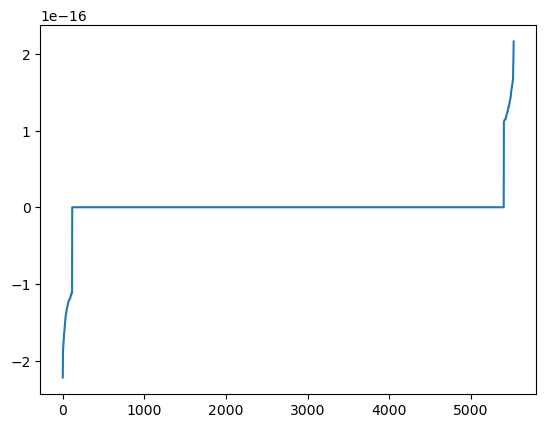

In [47]:
df33 = df_complete_over.copy()

df33['diff_Hauer'] = 1 /(df33['forecast_ssp42020'] / df33['CensusPop_20'])
df33['diff_NCAR'] = 1 /(df33['population_2020_ssp4'] / df33['CensusPop_20'])

df33['w1'] = df33['diff_Hauer'] 
df33['w2'] = df33['diff_NCAR']

df33['w1'].replace(np.inf, 1, inplace =  True,)
df33['w2'].replace(np.inf, 1, inplace =  True)

df33['w3'] = df33['w1']/ 2
df33['w4'] = df33['w2']/ 2

df33['new'] = df33['w3']* df33['forecast_ssp42020'] + df33['w4'] * df33['population_2020_ssp4']
print(np.sum(np.abs(df33['new'] - df33['CensusPop_20'])) ) #/ np.sum(df_complete['CensusPop_20']))
df33['%diff'] = ((df33['CensusPop_20']-df33['new'])) /df33['CensusPop_20']
df33['diff'] = ((df33['CensusPop_20']-df33['new']))

df33['%diff'].sort_values().reset_index(drop=True).plot()

In [48]:
df11.shape, df22.shape, df33.shape

((15795, 265), (10249, 265), (5524, 265))

In [49]:
# merging all together
df_with_weights = pd.concat([df11, df22, df33], axis =0).reset_index(drop=True)

In [50]:
# df_with_weights[['NAME', 'CensusPop_20', 'forecast_ssp42020', 'population_2020_ssp4', 'new', 'w3', 'w4']]

(31568, 257)


<Axes: >

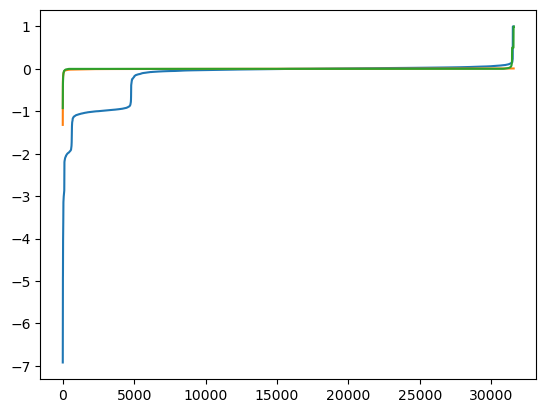

In [51]:
print(df_complete.shape)

((df_complete['CensusPop_20'] - df_complete['forecast_ssp42020'])/ df_complete['CensusPop_20']).sort_values().reset_index(drop=True).plot() 
((df_complete['CensusPop_20'] - df_complete['population_2020_ssp4'])/ df_complete['CensusPop_20']/100).sort_values().reset_index(drop=True).plot() 

df_with_weights['%diff'].sort_values().reset_index(drop=True).plot() # [df_complete['%diff'] !=1]

# Preparing data to forecast trend
1. Multiply by the weights
2. Sum weighted data
3. Concatenate all years to create df_for_forecast

In [52]:
df_w3 = df_with_weights.filter(regex= 'forecast').multiply(df_with_weights['w3'], axis="index")
df_w3.columns = df_w3.columns.str.split('_').str[1]
df_w4 = df_with_weights.filter(regex= 'population').multiply(df_with_weights['w4'], axis="index")
df_w4.columns = df_w4.columns.str.split('population_').str[1]

In [53]:
df_w4.columns = ['ssp12010', 'ssp12020', 'ssp12030', 'ssp12040', 'ssp12050',
                 'ssp12060', 'ssp12070', 'ssp12080', 'ssp12090', 'ssp12100',
                 'ssp22010', 'ssp22020', 'ssp22030', 'ssp22040', 'ssp22050',
                 'ssp22060', 'ssp22070', 'ssp22080', 'ssp22090', 'ssp22100',
                 'ssp32010', 'ssp32020', 'ssp32030', 'ssp32040', 'ssp32050',
                 'ssp32060', 'ssp32070', 'ssp32080', 'ssp32090', 'ssp32100',
                 'ssp42010', 'ssp42020', 'ssp42030', 'ssp42040', 'ssp42050',
                 'ssp42060', 'ssp42070', 'ssp42080', 'ssp42090', 'ssp42100',
                 'ssp52010', 'ssp52020', 'ssp52030', 'ssp52040', 'ssp52050',
                 'ssp52060', 'ssp52070', 'ssp52080', 'ssp52090', 'ssp52100']

In [54]:
df_2020 = df_w3.filter(regex='2020') + df_w4.filter(regex='2020')
df_2030 = df_w3.filter(regex='2030') + df_w4.filter(regex='2030')
df_2040 = df_w3.filter(regex='2040') + df_w4.filter(regex='2040')
df_2050 = df_w3.filter(regex='2050') + df_w4.filter(regex='2050')
df_2060 = df_w3.filter(regex='2060') + df_w4.filter(regex='2060')
df_2070 = df_w3.filter(regex='2070') + df_w4.filter(regex='2070')
df_2080 = df_w3.filter(regex='2080') + df_w4.filter(regex='2080')
df_2090 = df_w3.filter(regex='2090') + df_w4.filter(regex='2090')
df_2100 = df_w3.filter(regex='2100') + df_w4.filter(regex='2100')

In [55]:
# merging weighted summed datasets

In [56]:
df_for_forecast = pd.concat([df_2020, df_2030, df_2040, df_2050, df_2060, 
                             df_2070, df_2080, df_2090, df_2100, df_with_weights[['GEOID']]], axis =1)

In [57]:
df_for_forecast.to_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\df_cleaned_for_forecast.csv')

In [58]:
forecasted_df = df_for_forecast.copy()
# Check length of columns for each scenario
len(forecasted_df.filter(regex='ssp2').columns)

9

In [59]:
forecasted_df['find_trend_ssp1'] = forecasted_df[forecasted_df.filter(regex='ssp1').columns].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp2'] = forecasted_df[forecasted_df.filter(regex='ssp2').columns].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp3'] = forecasted_df[forecasted_df.filter(regex='ssp3').columns].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp4'] = forecasted_df[forecasted_df.filter(regex='ssp4').columns].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp5'] = forecasted_df[forecasted_df.filter(regex='ssp5').columns].astype(str).fillna('').apply(', '.join, axis=1)

# Mann Kendall test to find trend from forecasted data

In [60]:
import pymannkendall as mk
import numpy as np
test_res = []

column_name = ['find_trend_ssp1','find_trend_ssp2', 'find_trend_ssp3', 'find_trend_ssp4', 'find_trend_ssp5']

for i in range(0,len(column_name)):
    for j in range(0,len(forecasted_df[column_name])):
        test_res.append(mk.original_test(np.asarray([float(k) for k in forecasted_df.iloc[j][column_name[i]].split(',')]), alpha=0.05))  

for i in range(0,len(column_name)):
    new_col_name = 'result' + column_name[i][10:]
    forecasted_df[new_col_name] =  test_res[(i*len(forecasted_df)):(i+1)*len(forecasted_df)]

In [61]:
forecasted_df['future trend from SSP 1'] = ''
forecasted_df['future trend from SSP 2'] = ''
forecasted_df['future trend from SSP 3'] = ''
forecasted_df['future trend from SSP 4'] = ''
forecasted_df['future trend from SSP 5'] = ''

In [62]:
pd.options.mode.chained_assignment = None 
for i in range(len(forecasted_df)):
    forecasted_df['future trend from SSP 1'][i] = forecasted_df['result_ssp1'][i][0]
    forecasted_df['future trend from SSP 2'][i] = forecasted_df['result_ssp2'][i][0]
    forecasted_df['future trend from SSP 3'][i] = forecasted_df['result_ssp3'][i][0]
    forecasted_df['future trend from SSP 4'][i] = forecasted_df['result_ssp4'][i][0]
    forecasted_df['future trend from SSP 5'][i] = forecasted_df['result_ssp5'][i][0]

# Joining forecasted dataframe with spatial data

In [63]:
# =========== DEFINING df for use rest of the section
df = places_merged.merge(forecasted_df, left_on='GEOID', right_on='GEOID', how = 'left')

In [64]:
df[['GEOID', 'NAME', 'NAMELSAD', 'LSAD','ALAND', 'CensusPop_20','P_19', 'P_20', 'trend', 'label', 'State',
       'ssp12020', 'ssp22020', 'ssp32020', 'ssp42020', 'ssp52020', 'ssp12030',
       'ssp22030', 'ssp32030', 'ssp42030', 'ssp52030', 'ssp12040', 'ssp22040',
       'ssp32040', 'ssp42040', 'ssp52040', 'ssp12050', 'ssp22050', 'ssp32050',
       'ssp42050', 'ssp52050', 'ssp12060', 'ssp22060', 'ssp32060', 'ssp42060',
       'ssp52060', 'ssp12070', 'ssp22070', 'ssp32070', 'ssp42070', 'ssp52070',
       'ssp12080', 'ssp22080', 'ssp32080', 'ssp42080', 'ssp52080', 'ssp12090',
       'ssp22090', 'ssp32090', 'ssp42090', 'ssp52090', 'ssp12100', 'ssp22100',
       'ssp32100', 'ssp42100', 'ssp52100', 'future trend from SSP 1',
       'future trend from SSP 2', 'future trend from SSP 3',
       'future trend from SSP 4', 'future trend from SSP 5', 
    ]].to_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\forecasted_trend.csv')

In [65]:
df[['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 'future trend from SSP 4',
    'future trend from SSP 5']].apply(pd.Series.value_counts)/ df['future trend from SSP 2'].value_counts().sum()

,future trend from SSP 1,future trend from SSP 2,future trend from SSP 3,future trend from SSP 4,future trend from SSP 5
decreasing,0.454764,0.485682,0.846807,0.635675,0.094938
increasing,0.421851,0.413425,0.032976,0.181481,0.858528
no trend,0.123384,0.100893,0.120217,0.182843,0.046534


In [66]:
df['future trend from SSP 2'].value_counts().sum(), df.shape
df[['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 'future trend from SSP 4', 'future trend from SSP 5']].count()

future trend from SSP 1    31568
future trend from SSP 2    31568
future trend from SSP 3    31568
future trend from SSP 4    31568
future trend from SSP 5    31568
dtype: int64

In [67]:
# Cartographic boundary for plotting
US_counties_cb = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\cb_2020_us_county_5m.zip') # tl_2020_us_county
US_states_cb = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\cb_2020_us_state_5m.zip')  # tl_2020_us_state

# source: https://gis.stackexchange.com/questions/141580/which-projection-is-best-for-mapping-the-contiguous-united-states
US_states_cb = US_states_cb.to_crs('EPSG:9311')
US_counties_cb = US_counties_cb.to_crs('EPSG:9311')

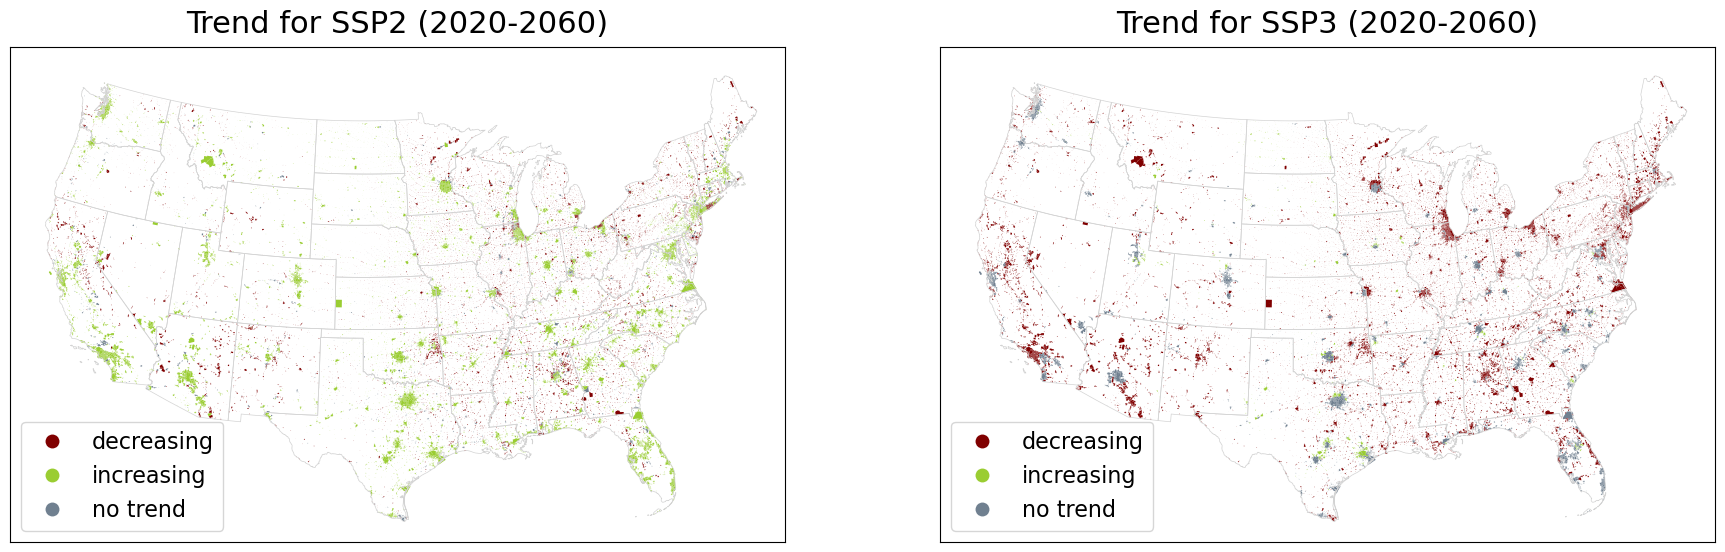

In [68]:
df = df.to_crs('EPSG:9311')
#US_states = US_states.to_crs('EPSG:9311')
columns = ['future trend from SSP 2', 'future trend from SSP 3'] 
colors = ['maroon','yellowgreen','slategray']
title_dict = {'trend':'Trend from ACS data 2010-2020', 'future trend from SSP 1':'Trend for SSP1 (2020-2060)', 
              'future trend from SSP 2':'Trend for SSP2 (2020-2060)', 'future trend from SSP 3': 'Trend for SSP3 (2020-2060)',
              'future trend from SSP 4': 'Trend for SSP4 (2020-2060)', 'future trend from SSP 5':'Trend for SSP5 (2020-2060)'}

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22,12))

for ax,col in zip(ax.flatten(), columns):
    xlim = ([-2257388.37, 2695859.75]) 
    ylim = ([-2246944.04, 918095.9])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    cmap_colors = matplotlib.colors.ListedColormap(colors)
    base = US_states_cb.boundary.plot(ax =ax, edgecolor = 'lightgray', linewidth = 0.5)
    df.plot(ax =ax, column = col, cmap=cmap_colors, legend = True, legend_kwds={'loc': 'lower left','fontsize': 16, })
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax.set_title(title_dict.get(col), fontsize=22, pad=10)

fig.savefig(r'D:\Work\Box Sync\NC Figures\All Trends from forecast.png', dpi = 900)

In [69]:
df.columns

Index(['STATEFP', 'PLACEFP', 'PLACENS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
       'CLASSFP', 'PCICBSA', 'PCINECTA', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'CensusPop_20',
       'Pop_estimate', 'P_19', 'P_20', 'trend', 'label', 'State', '_merge',
       'ssp12020', 'ssp22020', 'ssp32020', 'ssp42020', 'ssp52020', 'ssp12030',
       'ssp22030', 'ssp32030', 'ssp42030', 'ssp52030', 'ssp12040', 'ssp22040',
       'ssp32040', 'ssp42040', 'ssp52040', 'ssp12050', 'ssp22050', 'ssp32050',
       'ssp42050', 'ssp52050', 'ssp12060', 'ssp22060', 'ssp32060', 'ssp42060',
       'ssp52060', 'ssp12070', 'ssp22070', 'ssp32070', 'ssp42070', 'ssp52070',
       'ssp12080', 'ssp22080', 'ssp32080', 'ssp42080', 'ssp52080', 'ssp12090',
       'ssp22090', 'ssp32090', 'ssp42090', 'ssp52090', 'ssp12100', 'ssp22100',
       'ssp32100', 'ssp42100', 'ssp52100', 'find_trend_ssp1',
       'find_trend_ssp2', 'find_trend_ssp3', 'find_trend_ssp4',
       'find_trend_ssp5', 'r

# Check density variation

In [70]:
df['density_km2'] = df['CensusPop_20'] *1000*1000 / df['ALAND']

In [71]:
df[df['density_km2'] != 0].groupby(['label'])['density_km2'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
1 severely depopulating,954.0,162.4,319.0,0.0,25.4,68.3,169.6,3728.3
2 moderately depopulating,1797.0,273.5,425.6,0.0,81.9,171.3,335.3,10856.8
3 slowly depopulating,8904.0,494.8,727.1,0.0,126.4,309.1,588.0,35050.5
4 fluctuating,1461.0,315.9,435.8,0.0,81.2,188.1,389.4,5056.3
5 slowly increasing,5602.0,793.0,1040.1,0.1,235.1,474.1,995.6,24038.5
6 moderately increasing,7260.0,506.0,702.5,0.0,137.7,310.1,617.5,18659.2
7 highly increasing,2991.0,280.8,455.1,0.1,45.2,133.1,321.6,5755.0


In [72]:
df[df['density_km2'] != 0].groupby('label')['density_km2'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
1 severely depopulating,954.0,162.4,319.0,0.0,25.4,68.3,169.6,3728.3
2 moderately depopulating,1797.0,273.5,425.6,0.0,81.9,171.3,335.3,10856.8
3 slowly depopulating,8904.0,494.8,727.1,0.0,126.4,309.1,588.0,35050.5
4 fluctuating,1461.0,315.9,435.8,0.0,81.2,188.1,389.4,5056.3
5 slowly increasing,5602.0,793.0,1040.1,0.1,235.1,474.1,995.6,24038.5
6 moderately increasing,7260.0,506.0,702.5,0.0,137.7,310.1,617.5,18659.2
7 highly increasing,2991.0,280.8,455.1,0.1,45.2,133.1,321.6,5755.0


In [73]:
df[df['density_km2'] != 0].groupby('future trend from SSP 1')['density_km2'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
future trend from SSP 1,,,,,,,,
decreasing,14356.0,277.95,315.56,0.00,75.89,190.32,373.06,5142.17
increasing,13317.0,727.47,1015.16,0.02,161.49,427.28,929.12,35050.55
no trend,3895.0,395.62,479.45,0.00,92.87,252.76,514.02,5253.10


In [74]:
df[df['density_km2'] != 0].groupby('future trend from SSP 2')['density_km2'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
future trend from SSP 2,,,,,,,,
decreasing,15332.0,283.46,324.65,0.00,76.78,192.32,379.26,5142.17
increasing,13051.0,732.55,1021.65,0.02,163.75,430.34,934.49,35050.55
no trend,3185.0,412.07,501.39,0.00,93.43,261.26,528.70,5253.10


In [75]:
df[df['density_km2'] != 0].groupby('future trend from SSP 4')['density_km2'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
future trend from SSP 4,,,,,,,,
decreasing,20067.0,314.79,382.50,0.00,81.02,206.18,410.52,8704.41
increasing,5729.0,755.08,1140.75,0.02,167.84,459.11,962.89,35050.55
no trend,5772.0,792.83,979.87,0.00,179.84,462.00,1048.11,12333.73


# Land area in depopulated cities 

In [76]:
print('Area of deopulating cities as percent of total populated area--- for SSP 1:')
print(df.groupby(['future trend from SSP 1'])['ALAND'].sum()/ df.groupby(['future trend from SSP 1'])['ALAND'].sum().sum())

print('Area of deopulating cities as percent of total populated area--- for SSP 2:')
print(df.groupby(['future trend from SSP 2'])['ALAND'].sum()/ df.groupby(['future trend from SSP 2'])['ALAND'].sum().sum())

print('Area of deopulating cities as percent of total populated area--- for SSP 4:')
print(df.groupby(['future trend from SSP 4'])['ALAND'].sum()/ df.groupby(['future trend from SSP 4'])['ALAND'].sum().sum())
print('\n')
print('This excludes area of any water bodies inside the cities.')

Area of deopulating cities as percent of total populated area--- for SSP 1:
future trend from SSP 1
decreasing    0.222568
increasing    0.642105
no trend      0.135327
Name: ALAND, dtype: float64
Area of deopulating cities as percent of total populated area--- for SSP 2:
future trend from SSP 2
decreasing    0.246666
increasing    0.646568
no trend      0.106766
Name: ALAND, dtype: float64
Area of deopulating cities as percent of total populated area--- for SSP 4:
future trend from SSP 4
decreasing    0.412311
increasing    0.331313
no trend      0.256376
Name: ALAND, dtype: float64


This excludes area of any water bodies inside the cities.


In [77]:
# df.groupby(['future trend from SSP 4'])['CensusPop_20'].sum()/ df.groupby(['future trend from SSP 4'])['CensusPop_20'].sum().sum()

In [78]:
df.groupby(['label'])['CensusPop_20'].sum()/ df.groupby(['future trend from SSP 4'])['CensusPop_20'].sum().sum()

label
1 severely depopulating      0.001073
2 moderately depopulating    0.005754
3 slowly depopulating        0.186541
4 fluctuating                0.006001
5 slowly increasing          0.386958
6 moderately increasing      0.365223
7 highly increasing          0.033063
Name: CensusPop_20, dtype: float64

In [79]:
df.groupby(['future trend from SSP 1'])['ALAND'].sum()/ df.groupby(['future trend from SSP 1'])['ALAND'].sum().sum()

future trend from SSP 1
decreasing    0.222568
increasing    0.642105
no trend      0.135327
Name: ALAND, dtype: float64

In [80]:
df.groupby(['future trend from SSP 4'])['ALAND'].sum()/ df.groupby(['future trend from SSP 4'])['ALAND'].sum().sum()

future trend from SSP 4
decreasing    0.412311
increasing    0.331313
no trend      0.256376
Name: ALAND, dtype: float64

C:\Users\uttar\AppData\Local\Temp\ipykernel_14648\2308685401.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Expected Trend", y="No of cities",


<Axes: xlabel='Expected Trend', ylabel='No of cities'>

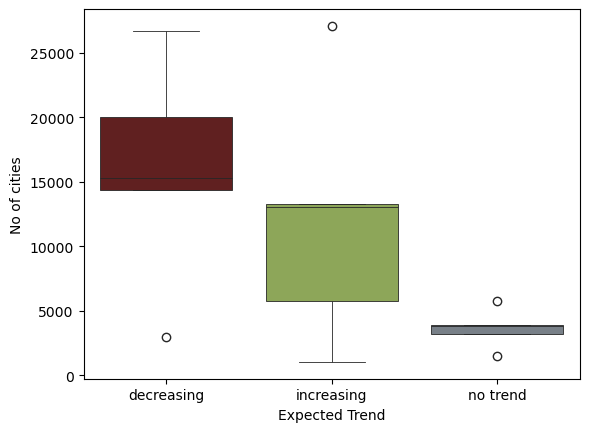

In [81]:
trend_sce_df = pd.DataFrame()
trend_sce_df['SSP 1'] = df['future trend from SSP 1'].value_counts()
trend_sce_df['SSP 2'] = df['future trend from SSP 2'].value_counts()
trend_sce_df['SSP 3'] = df['future trend from SSP 3'].value_counts()
trend_sce_df['SSP 4'] = df['future trend from SSP 4'].value_counts()
trend_sce_df['SSP 5'] = df['future trend from SSP 5'].value_counts()

import seaborn as sns
sns.boxplot(x="Expected Trend", y="No of cities", 
            data=pd.melt(trend_sce_df.T, var_name='Expected Trend', value_name='No of cities', col_level=None, ignore_index=False),
            palette = ['maroon','yellowgreen','slategray'],
            saturation=0.5,
            linewidth=0.6,
           )

In [82]:
df[df['density_km2'] != 0]['density_km2'].min()

0.003232994838342693

In [83]:
# Save the forecasted dataframe 
from datetime import date
today = date.today()

file_name = 'forecasted_trend_' + str(date.today())
# df.to_csv(r'D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\forecast trend output\\' + file_name + '.csv')

In [84]:
county_Projection[['ssp32020', 'ssp32040', 'ssp32050', 'ssp32060']].sum(), forecasted_df[['ssp32020', 'ssp32040', 'ssp32050', 'ssp32060', ]].sum()
# 245375572.0/3.287417e+08, 256977104.0/3.388857e+08, 255146017.0/3.342000e+08, 250260502.0/3.260763e+08

(ssp32020    3.287505e+08
 ssp32040    3.388928e+08
 ssp32050    3.342065e+08
 ssp32060    3.260822e+08
 dtype: float64,
 ssp32020    2.460211e+08
 ssp32040    2.571268e+08
 ssp32050    2.552045e+08
 ssp32060    2.503629e+08
 dtype: float64)

In [85]:
df['future trend from SSP 1'].value_counts().sum(), df['future trend from SSP 2'].value_counts().sum(), df['future trend from SSP 4'].value_counts().sum()

(31568, 31568, 31568)

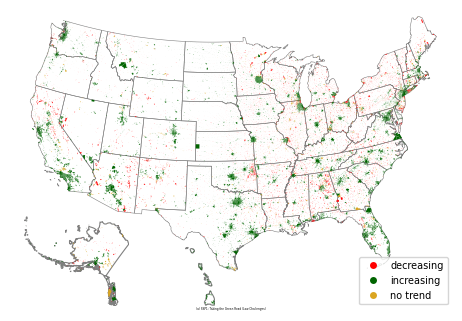

In [89]:
# import the United States shape file
# set state code as index, exclude states that we will never display
gdf = df.set_index('STATEFP') #.drop(index=['02', 'VI', 'MP', 'GU', 'AS'])
colors = ['red','darkgreen','goldenrod']

# column_name = ["future trend from SSP 2", "future trend from SSP 4"]
x_labels = {"future trend from SSP 1": "(a) SSP1: Taking the Green Road (Low Challenges)",
            "future trend from SSP 2": "(a) SSP2: Middle of the road (Intermediate Challenges)", 
            "future trend from SSP 4": '(b) SSP4: A Road Divided (Adaptation challenges dominate)'}
col= "future trend from SSP 1"

mm = 1/(10* 2.54)  # milimeters in inches

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(120*mm, 100*mm))


continental_ax = ax
alaska_ax = ax.inset_axes([.01, .01, .28, .30])
hawaii_ax = ax.inset_axes([.30, .01, .25, .2])
               
# Set bounds to fit desired areas in each plot
continental_ax.set_xlim(-2257388.37, 2695859.75)
continental_ax.set_ylim(-2546944.04, 808080.9)
continental_ax.set_title((x_labels[col]).strip('\"'), fontsize = 2, 
                     loc='center',  y=-0.03)

alaska_ax.set_xlim(-4383115.86156959, -1515327.22537998)
alaska_ax.set_ylim(1458524.37417163, 3919523.37426209)

hawaii_ax.set_xlim(-5812090.887043, -5452538.83170424)   # complete bounds 
hawaii_ax.set_ylim(-1064618.58269969, -431238.37803499)
               
               
US_states_cb.plot(ax=continental_ax, facecolor = 'none', edgecolor='gray', linewidth=0.4)
gdf.plot(column=col, 
             ax=continental_ax,
             cmap=matplotlib.colors.ListedColormap(colors), 
             legend = True,
             legend_kwds={'loc': 'lower right', 'fontsize': 7,
                         'markerscale': 0.5})

US_states_cb.plot(facecolor = 'none', edgecolor='gray', linewidth=0.8, ax=alaska_ax)
gdf.plot(column=col, cmap=matplotlib.colors.ListedColormap(colors), ax=alaska_ax) 

US_states_cb.plot(facecolor = 'none', edgecolor='gray', linewidth=0.8, ax=hawaii_ax)
gdf.plot(column=col, cmap=matplotlib.colors.ListedColormap(colors), ax=hawaii_ax,
                    missing_kwds = dict(color='black'))

    # remove ticks
for ax in [continental_ax, alaska_ax, hawaii_ax]:
    ax.set_yticks([])
    ax.set_xticks([])
    ax.axis('off')
    plt.tight_layout()
    plt.axis('off') 
        
fig.patch.set_visible(False)

fig.savefig(r'D:\Work\Box Sync\NC Figures\all states trend SSP 1' + '.png', dpi = 300,
           bbox_inches='tight')

# Plotting the future trends

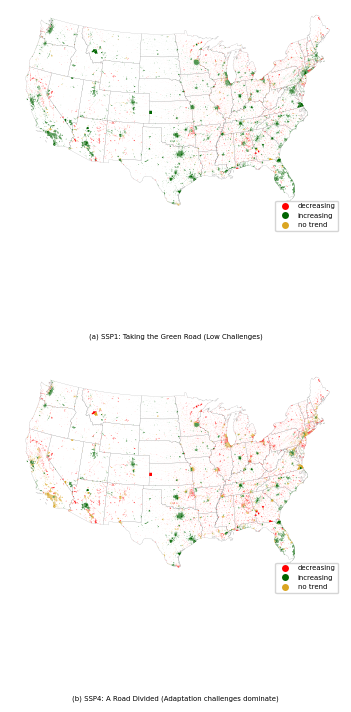

In [145]:
# import the United States shape file
# set state code as index, exclude states that we will never display
gdf = df.set_index('STATEFP') #.drop(index=['02', 'VI', 'MP', 'GU', 'AS'])
colors = ['red','darkgreen','goldenrod']

column_name = ["future trend from SSP 1", "future trend from SSP 4"]
x_labels = {"future trend from SSP 1": "(a) SSP1: Taking the Green Road (Low Challenges)", 
            "future trend from SSP 4": '(b) SSP4: A Road Divided (Adaptation challenges dominate)'}

mm = 1/(10* 2.54)  # milimeters in inches
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 25 )) #180*mm, 190*mm))

for ax, col in zip(axes.flatten(), column_name):
    continental_ax = ax
    alaska_ax = ax.inset_axes([.01, .01, .28, .30])
    hawaii_ax = ax.inset_axes([.30, .01, .25, .2])
               
    # Set bounds to fit desired areas in each plot
    continental_ax.set_xlim(-2257388.37, 2695859.75)
    continental_ax.set_ylim(-2546944.04, 808080.9)
    continental_ax.set_title((x_labels[col]).strip('\"'), fontsize = 5, 
                     loc='center',  y=-0.5)

    alaska_ax.set_xlim(-4383115.86156959, -1515327.22537998)
    alaska_ax.set_ylim(1458524.37417163, 3919523.37426209)

    hawaii_ax.set_xlim(-5812090.887043, -5452538.83170424)   # complete bounds 
    hawaii_ax.set_ylim(-1064618.58269969, -431238.37803499)
               
               
    US_states_cb.plot(ax=continental_ax, facecolor = 'none', edgecolor='gray', linewidth=0.1)
    gdf.plot(column=col, 
             ax=continental_ax,
             cmap=matplotlib.colors.ListedColormap(colors), 
             legend = True,
             legend_kwds={'loc': 'lower right', 'fontsize': 5,
                                              'markerscale': 0.5})

    # US_states_cb.plot(facecolor = 'none', edgecolor='gray', linewidth=0.1, ax=alaska_ax)
    # gdf.plot(column=col, cmap=matplotlib.colors.ListedColormap(colors), ax=alaska_ax) 

    # US_states_cb.plot(facecolor = 'none', edgecolor='gray', linewidth=0.1, ax=hawaii_ax)
    # gdf.plot(column=col, cmap=matplotlib.colors.ListedColormap(colors), ax=hawaii_ax,
    #                 missing_kwds = dict(color='black'))

    # remove ticks
    for ax in [continental_ax, alaska_ax, hawaii_ax]:
        ax.set_yticks([])
        ax.set_xticks([])
        ax.axis('off')
        plt.tight_layout()
        plt.axis('off') 
        
fig.patch.set_visible(False)

fig.savefig(r'D:\Work\Box Sync\NC Figures\all states trend SSP 1 and 4' + '.png', dpi = 300,
           bbox_inches='tight')

# Pecent cities with their future populating trend per State

C:\Users\uttar\AppData\Local\Temp\ipykernel_14648\1697184813.py:11: FutureWarning: The provided callable <function sum at 0x0000018C9B2FAE80> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  table = pd.pivot_table(percent_cities, values='GEOID', index=['STATEFP'], # 'future trend from SSP 3'


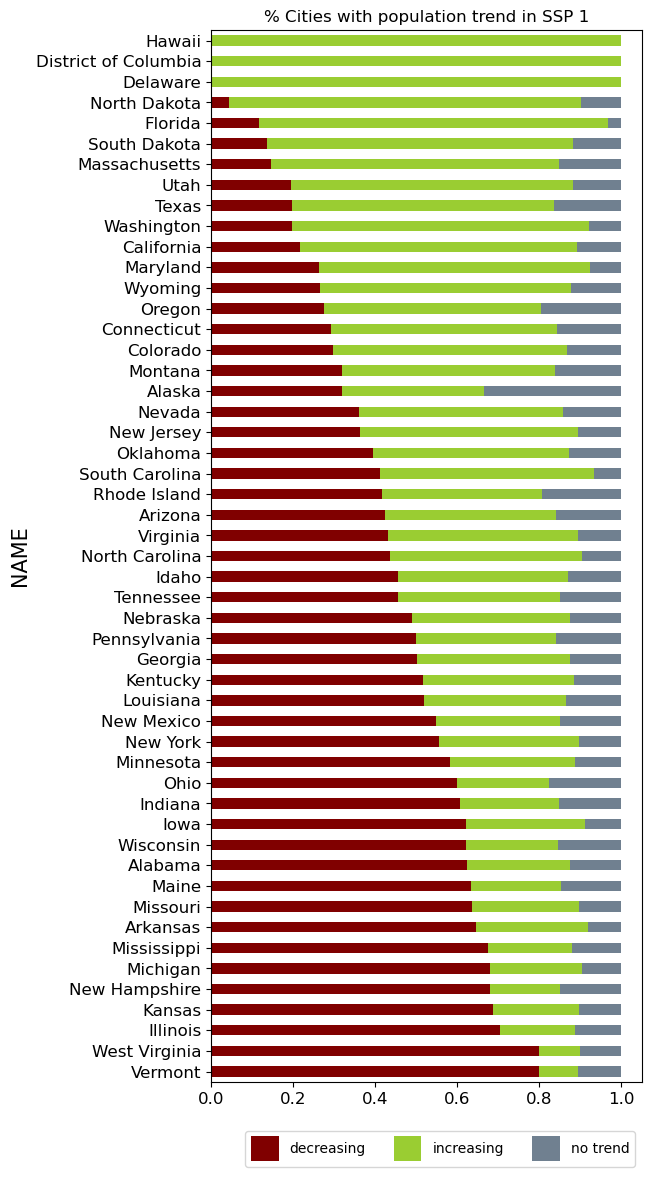

In [136]:
# get state names
state_names= US_states[['STATEFP', 'NAME']]
# Percent cities in each trend group
# pd.set_option('display.max_rows', None)

column_name = 'future trend from SSP 1'

percent_cities = (df.groupby(['STATEFP', column_name]).count()[['GEOID']] /
                  df.groupby(['STATEFP']).count()[['GEOID']]).reset_index()

table = pd.pivot_table(percent_cities, values='GEOID', index=['STATEFP'], # 'future trend from SSP 3'
                    columns=[column_name], aggfunc=np.sum).reset_index()

table = table.merge(state_names, on = 'STATEFP')
# table['sum'] = table[['1 severely depopulating', '2 moderately depopulating','3 slowly depopulating']].sum(axis =1)
table = table.sort_values('decreasing', ascending = False) 
table.drop(columns = ['STATEFP',], inplace = True)

colors = ['maroon','yellowgreen','slategray']
# colors = ['red', 'maroon', 'indianred', 'darkorange', 'limegreen','forestgreen', 'darkgreen', 'gray']
cmap=matplotlib.colors.ListedColormap(colors)

# plot a Stacked Bar Chart using matplotlib
ax = table.plot(
    x = 'NAME',
    kind = 'barh',
    stacked = True,
    cmap = cmap,
    title = '% Cities with population trend in SSP 1',
    mark_right = True,
    figsize=(6.8, 12))
# setting label sizes after creation
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.legend(bbox_to_anchor=(1.01, 1.00), loc='upper left', prop={'size': 15})
ax.legend(bbox_to_anchor=(1.0, -0.04), loc='best', prop={'size': 10},  ncol=3, handleheight=2.4, labelspacing=0.05)
ax.title.set_size(12)
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(r'D:\Work\Box Sync\NC Figures\pct cities with pop trend_' + str(column_name) + '.png',
            dpi = 300)

In [98]:
US_states.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62266296765,489206049,+38.6472854,-080.6183274,"POLYGON ((1561561.458 -483489.278, 1561609.307..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138958484319,45975808217,+28.3989775,-082.5143005,"MULTIPOLYGON (((1310991.956 -1534801.808, 1310..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143778461053,6216594318,+40.1028754,-089.1526108,"POLYGON ((742577.181 -445241.678, 743372.372 -..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206232157570,18949864226,+46.3159573,-094.1996043,"POLYGON ((245507.090 186209.715, 245510.348 18..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25151895765,6979171386,+38.9466584,-076.6744939,"POLYGON ((1914684.305 -379454.615, 1914689.752..."


In [99]:
# table[table['decreasing'] > 0.50].reset_index()
print('States with 50% or above no of cities with a decreasing trend for: ')

table[table['decreasing'] >0.5]['decreasing'].count()/ table['decreasing'].count()

States with 50% or above no of cities with a decreasing trend for: 


0.5

In [100]:
(df.groupby(['label'])['NAME'].count()*100/df.groupby(['label'])['NAME'].count().sum()).round(1)

label
1 severely depopulating       3.3
2 moderately depopulating     6.2
3 slowly depopulating        30.7
4 fluctuating                 5.0
5 slowly increasing          19.3
6 moderately increasing      25.1
7 highly increasing          10.3
Name: NAME, dtype: float64

In [143]:
df.groupby(['future trend from SSP 1']).size()

future trend from SSP 1
decreasing    14356
increasing    13317
no trend       3895
dtype: int64

In [144]:
df['future trend from SSP 2'].value_counts().sum()

31568

In [138]:
(df.groupby(['label', 'future trend from SSP 4'])['NAME'].count()*100/df.groupby(['label'])['NAME'].count()).round(1)

label                      future trend from SSP 4
1 severely depopulating    decreasing                 76.4
                           increasing                 11.5
                           no trend                   12.1
2 moderately depopulating  decreasing                 79.5
                           increasing                 10.1
                           no trend                   10.4
3 slowly depopulating      decreasing                 75.1
                           increasing                  9.8
                           no trend                   15.1
4 fluctuating              decreasing                 73.4
                           increasing                 12.0
                           no trend                   14.5
5 slowly increasing        decreasing                 49.8
                           increasing                 21.6
                           no trend                   28.7
6 moderately increasing    decreasing                 52.6
     

In [102]:
(df.groupby(['label', 'future trend from SSP 4'])['NAME'].count()*100/df.groupby(['label', 'future trend from SSP 2'])['NAME'].count().sum()).round(1).to_frame()

NAME
label                     future trend from SSP 4      
1 severely depopulating   decreasing                2.5
                          increasing                0.4
                          no trend                  0.4
2 moderately depopulating decreasing                4.9
                          increasing                0.6
                          no trend                  0.6
3 slowly depopulating     decreasing               23.1
                          increasing                3.0
                          no trend                  4.6
4 fluctuating             decreasing                3.7
                          increasing                0.6
                          no trend                  0.7
5 slowly increasing       decreasing                9.6
                          increasing                4.2
                          no trend                  5.5
6 moderately increasing   decreasing               13.2
                          increasing                7.2
                          no trend                  4.7
7 highly increasing       decreasing                6.3
                          increasing                2.4
                          no trend                  1.6

In [103]:
(df.groupby(['future trend from SSP 1','label',])['NAME'].count()*100/df.groupby(['label'])['NAME'].count()).round(1)

future trend from SSP 1  label                    
decreasing               1 severely depopulating      59.5
                         2 moderately depopulating    63.4
                         3 slowly depopulating        54.7
                         4 fluctuating                55.9
                         5 slowly increasing          31.3
                         6 moderately increasing      36.7
                         7 highly increasing          42.8
increasing               1 severely depopulating      27.3
                         2 moderately depopulating    24.9
                         3 slowly depopulating        31.4
                         4 fluctuating                30.6
                         5 slowly increasing          56.6
                         6 moderately increasing      52.6
                         7 highly increasing          44.2
no trend                 1 severely depopulating      13.2
                         2 moderately depopulating    11.7
     

In [104]:
(df.groupby(['future trend from SSP 2','label',]).size()*100/df.groupby(['future trend from SSP 1','label',]).size().sum()).round(1)

future trend from SSP 2  label                    
decreasing               1 severely depopulating       2.0
                         2 moderately depopulating     4.1
                         3 slowly depopulating        18.0
                         4 fluctuating                 3.0
                         5 slowly increasing           6.6
                         6 moderately increasing       9.9
                         7 highly increasing           4.8
increasing               1 severely depopulating       0.9
                         2 moderately depopulating     1.5
                         3 slowly depopulating         9.4
                         4 fluctuating                 1.5
                         5 slowly increasing          10.7
                         6 moderately increasing      13.0
                         7 highly increasing           4.5
no trend                 1 severely depopulating       0.4
                         2 moderately depopulating     0.6
     

# Regional variation of density

In [106]:
# Region 1: Northeast, Region 2: Midwest, Region 3: South, Region 4: West source: wiki
df = df.merge(US_states[['REGION', 'DIVISION', 'STATEFP']], on = 'STATEFP')

In [107]:
df['STATEFP'].unique(), df['REGION'].unique()

(array(['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13',
        '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
        '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
        '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48',
        '49', '50', '51', '53', '54', '55', '56'], dtype=object),
 array(['3', '4', '1', '2'], dtype=object))

In [108]:
df.groupby(['REGION','future trend from SSP 2'])['density_km2'].describe()

count         mean          std       min  \
REGION future trend from SSP 2                                               
1      decreasing               2513.0   479.749693   522.696232  3.458897   
       increasing               1798.0  1309.505418  1616.344547  1.365161   
       no trend                  505.0   767.743270   653.902895  1.944113   
2      decreasing               6254.0   315.753998   285.071854  0.764053   
       increasing               2986.0   533.751289   547.974721  0.203625   
       no trend                  969.0   441.518184   430.575844  0.145928   
3      decreasing               4598.0   189.808183   184.707474  0.923130   
       increasing               4950.0   632.708945   877.691755  0.520646   
       no trend                  948.0   286.250689   346.024748  1.861159   
4      decreasing               1967.0   148.909133   208.304267  0.003233   
       increasing               3317.0   747.749767  1020.154824  0.019661   
       no trend                  763.0   295.588592   514.848711  0.004819   

                                       25%         50%          75%  \
REGION future trend from SSP 2                                        
1      decreasing               140.289742  287.480070   630.837305   
       increasing               418.604279  863.948105  1618.773059   
       no trend                 268.421203  572.611315  1113.963414   
2      decreasing               118.740131  257.765565   437.354027   
       increasing               163.065908  389.622866   701.013422   
       no trend                 147.844289  343.431195   602.209177   
3      decreasing                58.708468  134.541819   263.878906   
       increasing               168.498242  388.341381   786.646279   
       no trend                  89.461780  187.962771   363.226838   
4      decreasing                18.884705   61.522007   199.792497   
       increasing                88.814450  363.010143  1071.965329   
       no trend                  25.648356  106.757319   359.455146   

                                         max  
REGION future trend from SSP 2                
1      decreasing                4103.695866  
       increasing               24038.519242  
       no trend                  4186.021005  
2      decreasing                5142.168139  
       increasing                5661.310260  
       no trend                  5253.099519  
3      decreasing                2313.601185  
       increasing               35050.548646  
       no trend                  4317.384001  
4      decreasing                2272.037114  
       increasing               10856.805045  
       no trend                  5119.891813

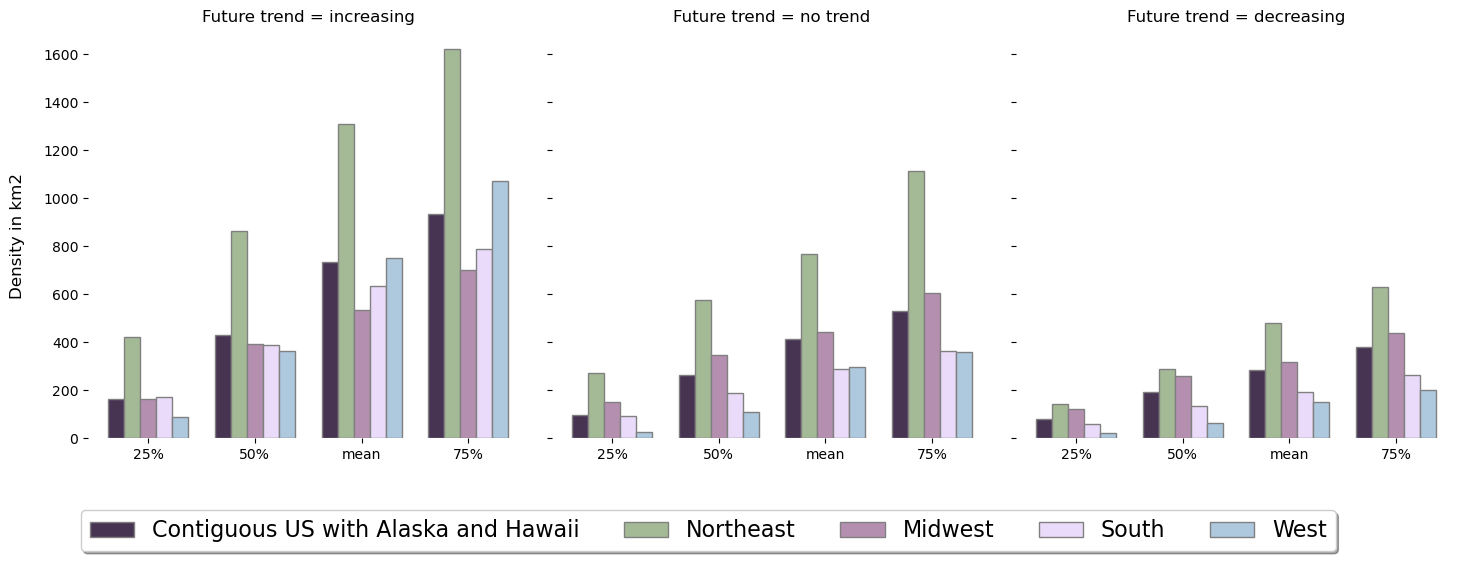

In [109]:
trend_types = ['increasing', 'no trend', 'decreasing']

df_0999 = df.groupby(['REGION','future trend from SSP 2'])['density_km2'].describe()[['25%', '50%','mean', '75%', 'max']].reset_index()
df_mainland = df.groupby(['future trend from SSP 2'])['density_km2'].describe()[['25%', '50%','mean', '75%', 'max']].reset_index()

    
fig, axes = plt.subplots(nrows=1, ncols=3, sharex='col', sharey='row', figsize=(15, 5))

for ax, trend_type in zip(axes.flatten(), trend_types):

    df_plot = pd.concat([df_0999[df_0999['future trend from SSP 2'] == trend_type], 
                    df_mainland[df_mainland['future trend from SSP 2'] == trend_type]], 
                    ignore_index = True)

    df_plot['REGION'] = df_plot['REGION'].replace({'1':'Northeast',
                                               '2':'Midwest',
                                               '3':'South',
                                               '4':'West',
                                               np.nan:'Contiguous US with Alaska and Hawaii'})


    NE = df_plot[df_plot['REGION'] =='Northeast'][['25%', '50%', 'mean', '75%']].values[0]   #[1350,425,884,1702,]
    MW = df_plot[df_plot['REGION'] =='Midwest'][['25%', '50%', 'mean', '75%']].values[0]    #[527,158,380,687,]
    S =  df_plot[df_plot['REGION'] =='South'][['25%', '50%', 'mean', '75%']].values[0]    #[636,164,389,804,]
    W =  df_plot[df_plot['REGION'] =='West'][['25%', '50%', 'mean', '75%']].values[0]    #[747,88,360,1068,]
    MS = df_plot[df_plot['REGION'] =='Contiguous US with Alaska and Hawaii'][['25%', '50%', 'mean', '75%']].values[0]   #[735,158,426,936,]

    n=len(MS)
    r = np.arange(n)
    width = .15

    ax.bar(r, MS, color = '#473452', width = width, edgecolor = 'gray', label='Contiguous US with Alaska and Hawaii',)
    ax.bar(r + width, NE, color = '#a4b996',  width = width, edgecolor = 'gray', label='Northeast',)
    ax.bar(r + 2*width, MW, color = '#b58fb0',  width = width, edgecolor = 'gray', label='Midwest',)
    ax.bar(r + 3*width, S, color = '#e9dbf9',  width = width, edgecolor = 'gray', label='South',)
    ax.bar(r + 4*width, W, color = '#aec8de',  width = width, edgecolor = 'gray', label='West',)
    
    ax.set_title("Future trend = " + str(trend_type))
    ax.set_xticks(r + 2*width,['25%','50%','mean','75%'])
    ax.set_frame_on(False)

fig.supylabel('Density in km2')
plt.rcParams['font.size'] = 16
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-0.7, -0.15),
          fancybox=True, shadow=True, ncol=5)

plt.show()
fig.savefig(r'D:\Work\Box Sync\NC Figures\density_variation' + '.png', dpi = 300,
           bbox_inches='tight')

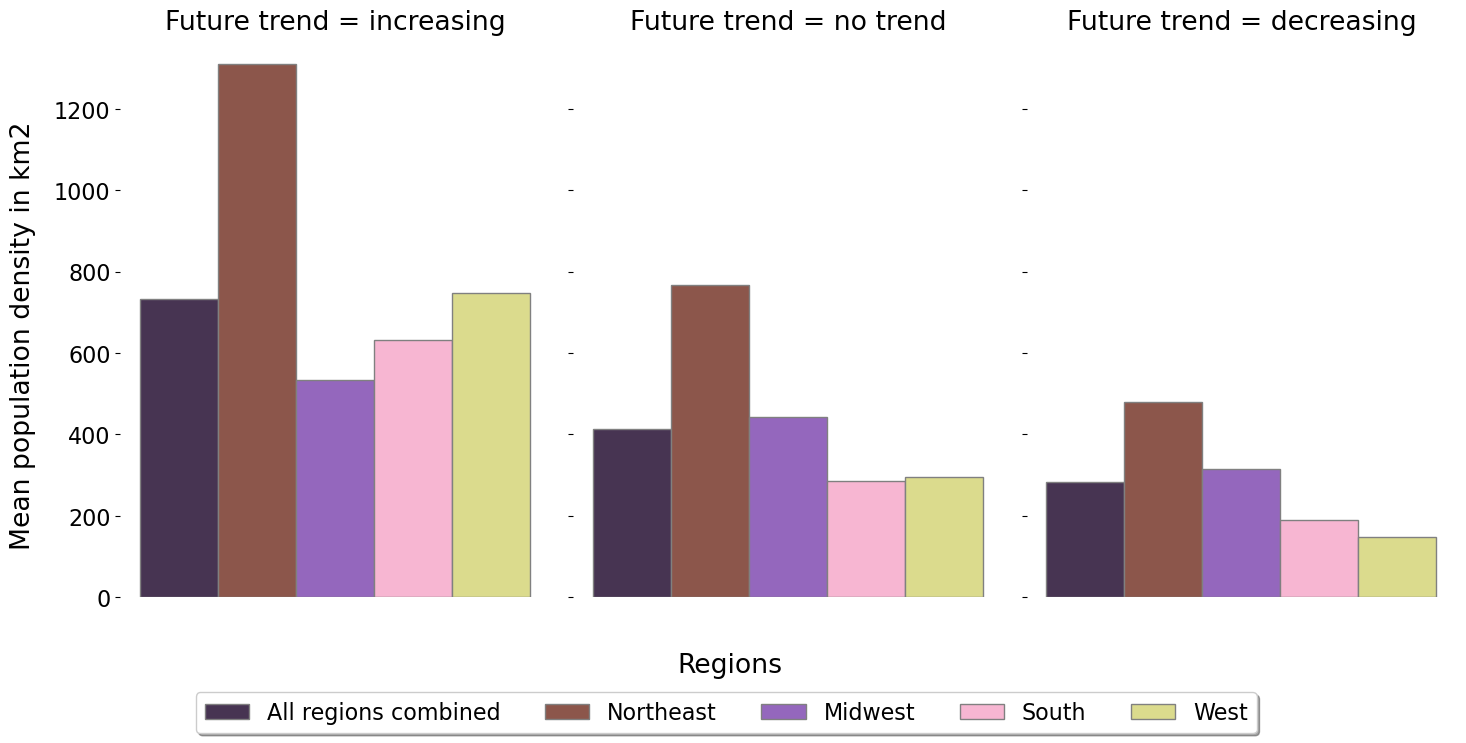

In [121]:
trend_types = ['increasing', 'no trend', 'decreasing']

df_0999 = df.groupby(['REGION','future trend from SSP 2'])['density_km2'].describe()[['25%', '50%','mean', '75%', 'max']].reset_index()
df_mainland = df.groupby(['future trend from SSP 2'])['density_km2'].describe()[['25%', '50%','mean', '75%', 'max']].reset_index()

    
fig, axes = plt.subplots(nrows=1, ncols=3, sharex='col', sharey='row', figsize=(15, 7))

for ax, trend_type in zip(axes.flatten(), trend_types):

    df_plot = pd.concat([df_0999[df_0999['future trend from SSP 2'] == trend_type], 
                    df_mainland[df_mainland['future trend from SSP 2'] == trend_type]], 
                    ignore_index = True)

    df_plot['REGION'] = df_plot['REGION'].replace({'1':'Northeast',
                                               '2':'Midwest',
                                               '3':'South',
                                               '4':'West',
                                               np.nan:'All regions combined'}) # Contiguous US with Alaska and Hawaii


    NE = df_plot[df_plot['REGION'] =='Northeast'][['mean']].values[0]   #[1350,425,884,1702,]
    MW = df_plot[df_plot['REGION'] =='Midwest'][['mean']].values[0]    #[527,158,380,687,]
    S =  df_plot[df_plot['REGION'] =='South'][['mean']].values[0]    #[636,164,389,804,]
    W =  df_plot[df_plot['REGION'] =='West'][['mean']].values[0]    #[747,88,360,1068,]
    MS = df_plot[df_plot['REGION'] == 'All regions combined'][['mean']].values[0]   #[735,158,426,936,]

    n=len(MS)
    r = np.arange(n)
    width = .05

   
    ax.bar(r, MS, color = '#473452', width = width, edgecolor = 'gray', label='All regions combined',)
    ax.bar(r + width, NE, color = '#8C564B',  width = width, edgecolor = 'gray', label='Northeast',)
    ax.bar(r + 2*width, MW, color = '#9467BD',  width = width, edgecolor = 'gray', label='Midwest',)
    ax.bar(r + 3*width, S, color = '#F7B6D2',  width = width, edgecolor = 'gray', label='South',)
    ax.bar(r + 4*width, W, color = '#DBDB8D',  width = width, edgecolor = 'gray', label='West',)
    
    ax.set_title("Future trend = " + str(trend_type))
    ax.set_xticks([]) #r + 2*width,['Regions'])
    ax.set_frame_on(False)

fig.supylabel('Mean population density in km2')
fig.supxlabel('Regions')

plt.rcParams['font.size'] = 16
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-0.7, -0.15),
          fancybox=True, shadow=True, ncol=5)

plt.show()
fig.savefig(r'D:\Work\Box Sync\NC Figures\density_variation' + '.png', dpi = 300,
           bbox_inches='tight')

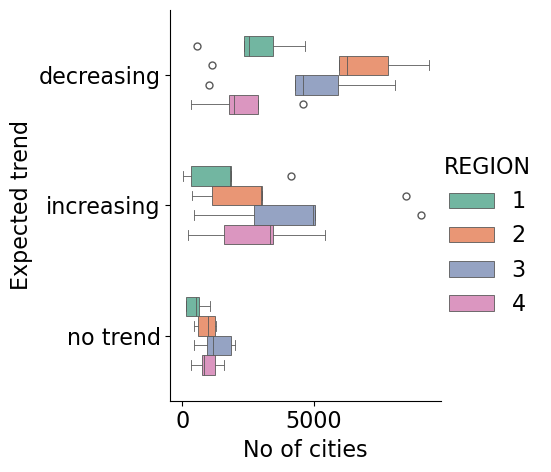

In [111]:
trend_sce_df = pd.DataFrame()
trend_sce_df['SSP 1'] = df.groupby('REGION')['future trend from SSP 1'].value_counts()
trend_sce_df['SSP 2'] = df.groupby('REGION')['future trend from SSP 2'].value_counts()
trend_sce_df['SSP 3'] = df.groupby('REGION')['future trend from SSP 3'].value_counts()
trend_sce_df['SSP 4'] = df.groupby('REGION')['future trend from SSP 4'].value_counts()
trend_sce_df['SSP 5'] = df.groupby('REGION')['future trend from SSP 5'].value_counts()
data = pd.melt(trend_sce_df, value_name='No of cities', col_level=None, ignore_index=False).reset_index()
data.rename({"future trend from SSP 1": 'Expected trend'}, axis = 1, inplace = True)

import seaborn as sns
sns.catplot(x="No of cities", y='Expected trend', 
            data=data,
            palette =sns.set_palette('Set2'),
            kind = 'box',
            hue = 'REGION',
            width = 0.6,
            # saturation=0.5,
            linewidth=0.6,
           )

In [112]:
pd.set_option('display.max_rows', 10)
plot_trend_change = df.groupby(['REGION', 'future trend from SSP 2', 'label'])['density_km2'].describe().round(2).reset_index() #count()

In [113]:
# sns.catplot(x=plot_trend_change.index, y="mean", kind="box", data=plot_trend_change, col="REGION", hue = 'label');

In [114]:
# sns.catplot(data = plot_trend_change, y = 'future trend from SSP 2', x = 'mean',  col="REGION", hue = 'label', kind='swarm')

In [115]:
pd.set_option('display.max_rows', 50)
df[df['density_km2'] != 0].groupby(['REGION','label'])['density_km2'].describe().round(2)

count     mean      std    min     25%  \
REGION label                                                                
1      1 severely depopulating      67.0   285.74   310.34   1.94   99.52   
       2 moderately depopulating   257.0   379.37   435.95   3.46  143.15   
       3 slowly depopulating      1689.0   853.39   794.66   1.37  259.04   
       4 fluctuating               169.0   461.10   469.95   8.37  141.26   
       5 slowly increasing        1043.0  1330.80  1723.72  12.06  394.97   
       6 moderately increasing     747.0   702.23  1275.25   3.51  196.72   
       7 highly increasing         233.0   379.95   468.06   3.79  126.26   
2      1 severely depopulating     278.0   154.36   169.47   1.63   43.88   
       2 moderately depopulating   648.0   256.36   234.67   4.08   98.54   
       3 slowly depopulating      3340.0   451.85   468.64   0.15  172.24   
       4 fluctuating               554.0   289.65   264.48   0.65  109.18   
       5 slowly increasing        1809.0   554.76   477.90   5.09  246.85   
       6 moderately increasing    2239.0   368.23   308.49   0.40  151.59   
       7 highly increasing         792.0   237.67   249.82   0.76   60.05   
3      1 severely depopulating     337.0   204.01   445.56   1.39   30.89   
       2 moderately depopulating   608.0   252.06   338.62   3.71   75.52   
       3 slowly depopulating      2576.0   366.47   807.59   0.92  102.47   
       4 fluctuating               486.0   305.27   498.04   4.37   80.81   
       5 slowly increasing        1729.0   607.50   710.43   2.55  183.83   
       6 moderately increasing    2691.0   497.77   647.09   4.94  130.03   
       7 highly increasing        1139.0   334.05   529.21   0.52   59.12   
4      1 severely depopulating     272.0    88.61   217.61   0.02   10.42   
       2 moderately depopulating   284.0   262.95   770.74   0.02   28.33   
       3 slowly depopulating      1299.0   393.81   855.13   0.00   29.90   
       4 fluctuating               252.0   297.01   554.04   0.04   29.41   
       5 slowly increasing        1021.0   979.79  1075.10   0.13  185.19   
       6 moderately increasing    1583.0   622.42   769.37   0.01   97.25   
       7 highly increasing         827.0   220.87   480.29   0.05   17.72   

                                     50%      75%       max  
REGION label                                                 
1      1 severely depopulating    170.84   348.42   1274.33  
       2 moderately depopulating  235.48   439.51   3333.38  
       3 slowly depopulating      621.20  1213.06   7330.48  
       4 fluctuating              326.49   618.84   3605.08  
       5 slowly increasing        870.12  1620.61  24038.52  
       6 moderately increasing    382.56   749.00  18659.18  
       7 highly increasing        235.29   491.47   4540.34  
2      1 severely depopulating     97.86   202.83   1316.13  
       2 moderately depopulating  199.63   347.56   2099.65  
       3 slowly depopulating      347.96   564.95   5661.31  
       4 fluctuating              229.18   417.29   2813.83  
       5 slowly increasing        442.43   697.64   4959.73  
       6 moderately increasing    300.24   505.94   3770.50  
       7 highly increasing        166.30   334.52   3101.93  
3      1 severely depopulating     74.20   171.32   3728.29  
       2 moderately depopulating  147.96   298.52   4317.38  
       3 slowly depopulating      230.48   421.92  35050.55  
       4 fluctuating              159.58   302.96   5056.25  
       5 slowly increasing        369.03   720.04   7816.00  
       6 moderately increasing    285.45   611.29   8536.02  
       7 highly increasing        155.02   376.47   5755.05  
4      1 severely depopulating     27.14    75.31   2441.88  
       2 moderately depopulating  104.39   286.19  10856.81  
       3 slowly depopulating      126.73   384.39   8283.40  
       4 fluctuating              101.82   334.15   4514.41  
       5 slowly increasing        628.02  1401.70 

In [116]:
# df[df['P_20'] >100000].groupby('future trend from SSP 3')['density_km2'].describe().round(2)
pd.set_option('display.max_rows', 50)
df[df['density_km2'] != 0].groupby(['REGION', 'future trend from SSP 4', ])['density_km2'].describe().round(2)

count     mean      std    min     25%  \
REGION future trend from SSP 4                                            
1      decreasing               3438.0   572.79   625.46   1.37  163.81   
       increasing                333.0  1979.85  2676.96  21.27  679.15   
       no trend                 1045.0  1262.47  1288.52  14.27  439.22   
2      decreasing               7816.0   334.44   311.32   0.15  122.52   
       increasing               1122.0   450.14   447.94   1.00  122.26   
       no trend                 1271.0   690.22   662.61   0.38  244.89   
3      decreasing               5924.0   204.06   204.78   0.92   62.69   
       increasing               2710.0   750.70  1046.93   0.52  215.18   
       no trend                 1862.0   554.65   631.96   0.64  151.87   
4      decreasing               2889.0   181.63   282.00   0.00   21.34   
       increasing               1564.0   720.65   903.14   0.02  105.93   
       no trend                 1594.0   844.97  1162.57   0.00   86.70   

                                    50%      75%       max  
REGION future trend from SSP 4                              
1      decreasing                348.29   775.28   8704.41  
       increasing               1297.21  2297.42  24038.52  
       no trend                  849.00  1629.86  12333.73  
2      decreasing                268.37   457.08   5253.10  
       increasing                329.24   644.21   4959.73  
       no trend                  508.77   894.20   5661.31  
3      decreasing                143.85   282.45   4317.38  
       increasing                496.40   954.10  35050.55  
       no trend                  340.23   690.24   5755.05  
4      decreasing                 70.82   240.76   3972.55  
       increasing                386.80  1111.70  10856.81  
       no trend                  388.79  1171.87   8402.91

In [117]:
df[['P_19', 'P_20']].sum(), places_attr[['P_20', 'DP05_0001E_19', 'DP05_0001E_20']].sum()
# 244619308.0 - 242801094.0

(P_19    240851040.0
 P_20    242800934.0
 dtype: float64,
 P_20             244619308.0
 DP05_0001E_19    242691080.0
 DP05_0001E_20    244619308.0
 dtype: float64)

In [118]:
(df[['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 
    'future trend from SSP 4', 'future trend from SSP 5']].apply(pd.Series.value_counts)/df[['future trend from SSP 1', 'future trend from SSP 2', 
    'future trend from SSP 3', 'future trend from SSP 4','future trend from SSP 5']].apply(pd.Series.value_counts).sum()).round(2)

,future trend from SSP 1,future trend from SSP 2,future trend from SSP 3,future trend from SSP 4,future trend from SSP 5
decreasing,0.45,0.49,0.85,0.64,0.09
increasing,0.42,0.41,0.03,0.18,0.86
no trend,0.12,0.10,0.12,0.18,0.05


# Export forecasted trend


In [120]:
df[['STATEFP', 'GEOID', 'NAMELSAD', 'Pop_estimate', 'P_20', 'CensusPop_20', 'trend', 'label', 'State',  
    'future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 'future trend from SSP 4', 'future trend from SSP 5', 'REGION', 
    'DIVISION']].to_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\future trend from SSP' + '.csv')

# previous path = D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\forecast trend output

# Results for a Single State

In [119]:
df_IL = df[df['STATEFP']== '31']
df_IL.shape

(590, 88)

In [ ]:
(df_IL[['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 
    'future trend from SSP 4', 'future trend from SSP 5']].apply(pd.Series.value_counts)/df_IL[['future trend from SSP 1', 'future trend from SSP 2', 
    'future trend from SSP 3', 'future trend from SSP 4','future trend from SSP 5']].apply(pd.Series.value_counts).sum()).round(2)

In [ ]:
(df_IL.groupby(['future trend from SSP 2','label',])['NAME'].count()*100/df_IL.groupby(['label'])['NAME'].count()).round(1).to_frame()

In [ ]:
# set state code as index, exclude states that we will never display
gdf = df_IL.to_crs('epsg:9311') 
counties_IL = US_counties_cb[US_counties_cb['STATEFP'] == '31'].to_crs('epsg:9311') 

#.drop(index=['02', 'VI', 'MP', 'GU', 'AS'])
colors = ['maroon','darkgreen','gray']

column_name = ["future trend from SSP 1", "future trend from SSP 2","future trend from SSP 3", "future trend from SSP 4"]
# x_labels = {"future trend from SSP 2": "(a)", 
#             "future trend from SSP 4": '(b)'}


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(35, 20))

for ax, col in zip(axes.flatten(), column_name):
    counties_IL.plot(ax=ax, facecolor = 'none', edgecolor='gray', linewidth=0.4)
    gdf.plot(column=col, 
             ax=ax,
             cmap=matplotlib.colors.ListedColormap(colors), 
             legend = True,
             legend_kwds={'loc': 'lower left', 'fontsize': 25,})
    
    ax.set_title(col, fontdict={'fontsize': 25, 'fontweight': 'medium'})


    # remove ticks
    for ax in axes.flatten():
        ax.set_yticks([])
        ax.set_xticks([])
        ax.axis('off')
        plt.tight_layout()
        plt.axis('off') 
    
        
# fig.patch.set_visible(False)

In [ ]:


colors = ['maroon','darkgreen','gray']

column_name = ["future trend from SSP 4"]
# x_labels = {"future trend from SSP 2": "(a)", 
#             "future trend from SSP 4": '(b)'}


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(35, 20))

counties_IL.plot(ax=ax, facecolor = 'none', edgecolor='grey', linewidth=2)
gdf.plot(column=col, 
             ax=ax,
             cmap=matplotlib.colors.ListedColormap(colors), 
             legend = True,
             legend_kwds={'loc': 'lower left', 'fontsize': 34,})
    
ax.set_title("Future population trend for SSP 4", fontdict={'fontsize': 45, 'fontweight': 'medium'})

ax.set_yticks([])
ax.set_xticks([])
ax.axis('off')
plt.tight_layout()
plt.axis('off') 
fig.savefig(r'D:\Work\Box Sync\NC Figures\Future_trend_SSP4_31.png', dpi = 300, bbox_inches='tight')

In [ ]:
print(gdf.shape, counties_IL.shape)
gpd.sjoin(counties_IL, gdf, predicate='contains').groupby(['GEOID_right']).size()

In [ ]:
gdf.groupby('future trend from SSP 1').size()

In [ ]:
df_IL[df_IL['density_km2'] != 0].groupby(['label'])['density_km2'].describe().round(2)

In [ ]:
df_IL[df_IL['density_km2'] != 0].groupby(['future trend from SSP 2'])['density_km2'].describe().round(2)

In [ ]:
trend_sce_df = pd.DataFrame()
trend_sce_df['SSP 1'] = df_IL.groupby('future trend from SSP 1')['density_km2'].mean()
trend_sce_df['SSP 2'] = df_IL.groupby('future trend from SSP 2')['density_km2'].mean()
# trend_sce_df['SSP 3'] = df_IL.groupby('future trend from SSP 3')['density_km2'].mean()
trend_sce_df['SSP 4'] = df_IL.groupby('future trend from SSP 4')['density_km2'].mean()
# trend_sce_df['SSP 5'] = df_IL.groupby('future trend from SSP 5')['density_km2'].mean()
data = pd.melt(trend_sce_df, value_name='density in km2', col_level=None, ignore_index=False).reset_index()
data.rename({"future trend from SSP 1": 'Future trend'}, axis = 1, inplace = True)

import seaborn as sns
sns.catplot(y="density in km2", x='Future trend', 
            data=data,
            palette =sns.set_palette('Set2'),
            kind = 'box',
            # hue = 'REGION',
            width = 0.4,
            # saturation=0.5,
            linewidth=0.6,
           )

In [ ]:
trend_sce_df = pd.DataFrame()
trend_sce_df['SSP 1'] = df_IL.groupby('future trend from SSP 1')['density_km2'].max()
trend_sce_df['SSP 2'] = df_IL.groupby('future trend from SSP 2')['density_km2'].max()
# trend_sce_df['SSP 3'] = df_IL.groupby('future trend from SSP 3')['density_km2'].mean()
trend_sce_df['SSP 4'] = df_IL.groupby('future trend from SSP 4')['density_km2'].max()
# trend_sce_df['SSP 5'] = df_IL.groupby('future trend from SSP 5')['density_km2'].mean()
data = pd.melt(trend_sce_df, value_name='density in km2', col_level=None, ignore_index=False).reset_index()
data.rename({"future trend from SSP 1": 'Future trend'}, axis = 1, inplace = True)

import seaborn as sns
sns.catplot(y="density in km2", x='Future trend', 
            data=data,
            palette =sns.set_palette('Set2'),
            kind = 'box',
            # hue = 'REGION',
            width = 0.4,
            # saturation=0.5,
            linewidth=0.6,
           )
